In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet,LinearRegression
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests
from copy import deepcopy
from collections import namedtuple
from scipy import special


def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = special.fdtrc(dfbn, dfwn, f)   # equivalent to stats.f.sf
    return F_onewayResult(f, prob)

In [2]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-9_pHILIC_HSS_pos-neg_normalized.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[10:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9_updated_5_25_21_drug_annotation_excluded_6_23_21.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[(metadata["day-COVID"] == "d0_Yes") | (metadata["day-COVID"] == "d0_No")]
print(len(metadata_rel)," d0 Samples")

            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if row["day-COVID"] == "d0_No":
        val = -1
    else:
        if "es" in val:
            val = 1
        elif "o" in val:
            val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
patient_ids = []

for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
        patient_ids.append(metadata_dict[tmp]["WU-350"])

    else:
        vent_status.append(-2)
        metadata_for_samples.append(-2)
        patient_ids.append(-2)



print("found vent info for",len([x for x in vent_status if x != -2]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -2]
ICU_vals = np.array([x for x in vent_status if x != -2])

patient_ids = np.array(patient_ids)[samplesOfInterest]
#create sample matrix
samp_int = np.log2(areaData[samp][samplesOfInterest])
metadata_for_samples = [metadata_for_samples[x] for x in samplesOfInterest]

patient_ICU = {id:stat for id,stat in zip(patient_ids,ICU_vals)}
patient_ind = {id:i for id,i in zip(patient_ids,range(len(patient_ids)))}

var_imp = pd.read_csv("../data/var_importance_final_updated_6_23.csv",index_col=0)

vars_of_interest = []
for x in var_imp.index.values:
    index = 0
    for y in mol_names:
        if x == y:
            vars_of_interest.append(index)
            break
        index += 1 
        
samp_int = samp_int[:,vars_of_interest]
mol_names = var_imp["plot-name"].values

print(samp_int.shape)
var_imp

0  blanks
0  qc samples
706 research samples
322  d0 Samples
64  ICU+ samples
258 ICU- samples
found vent info for 322 covid_ d0 samples
(322, 22)


var_imp          plot-name
HSSpos_Cer_NS d18:1_16:0_17.788  0.001118  Cer-NS d18:1_16:0
HSSpos_Cer_NS d18:2_16:0_16.67   0.000905  Cer-NS d18:2_16:0
HSSpos_LPC 0:0/16:0_4.715       -0.000702       LPC 0:0/16:0
HSSpos_LPC 0:0/18:0_6.997       -0.001206       LPC 0:0/18:0
HSSpos_LPC 14:0/0:0_3.387       -0.000405       LPC 14:0/0:0
HSSpos_LPC 16:0/0:0_5.147       -0.000232       LPC 16:0/0:0
HSSpos_LPC 16:1/0:0_3.734        0.000187       LPC 16:1/0:0
HSSpos_LPC 17:0/0:0_6.28        -0.000472       LPC 17:0/0:0
HSSpos_LPC 18:0/0:0_7.547       -0.000484       LPC 18:0/0:0
HSSpos_LPC 18:1/0:0_5.589       -0.000179       LPC 18:1/0:0
HSSpos_LPC 18:2/0:0_4.195       -0.000797       LPC 18:2/0:0
HSSpos_LPC 20:2/0:0_6.105       -0.000893       LPC 20:2/0:0
HSSpos_LPC 20:3/0:0_4.813       -0.000095       LPC 20:3/0:0
HSSpos_LPC 20:4/0:0_4.03        -0.000689       LPC 20:4/0:0
HSSpos_PC 18:2_22:6_15.427      -0.000657       PC 18:2_22:6
HSSpos_PC 20:4_20:4_15.512      -0.000821       PC 20:4_20:4
HSSpos_PC 38:6_15.829           -0.000319            PC 38:6
HSSpos_PE 16:0_18:2_16.83        0.001923       PE 16:0_18:2
HSSpos_PE 16:0_20:4_16.641       0.000716       PE 16:0_20:4
pHILICneg_87_L Serine           -0.001287             Serine
pHILICpos_135_1 Methyladenosine  0.001322  1-Methyladenosine
pHILICpos_196_Kynurenic acid     0.001349        Kynurenate

4.0 13.237618737982682 305 0.0 113.0
-1.791304347826087 6.656145447007618 115
6.226086956521739 7.6306713700470645 115
Ttest_indResult(statistic=0.8659216962584052, pvalue=0.3872182803585087)


<Figure size 3000x2000 with 0 Axes>

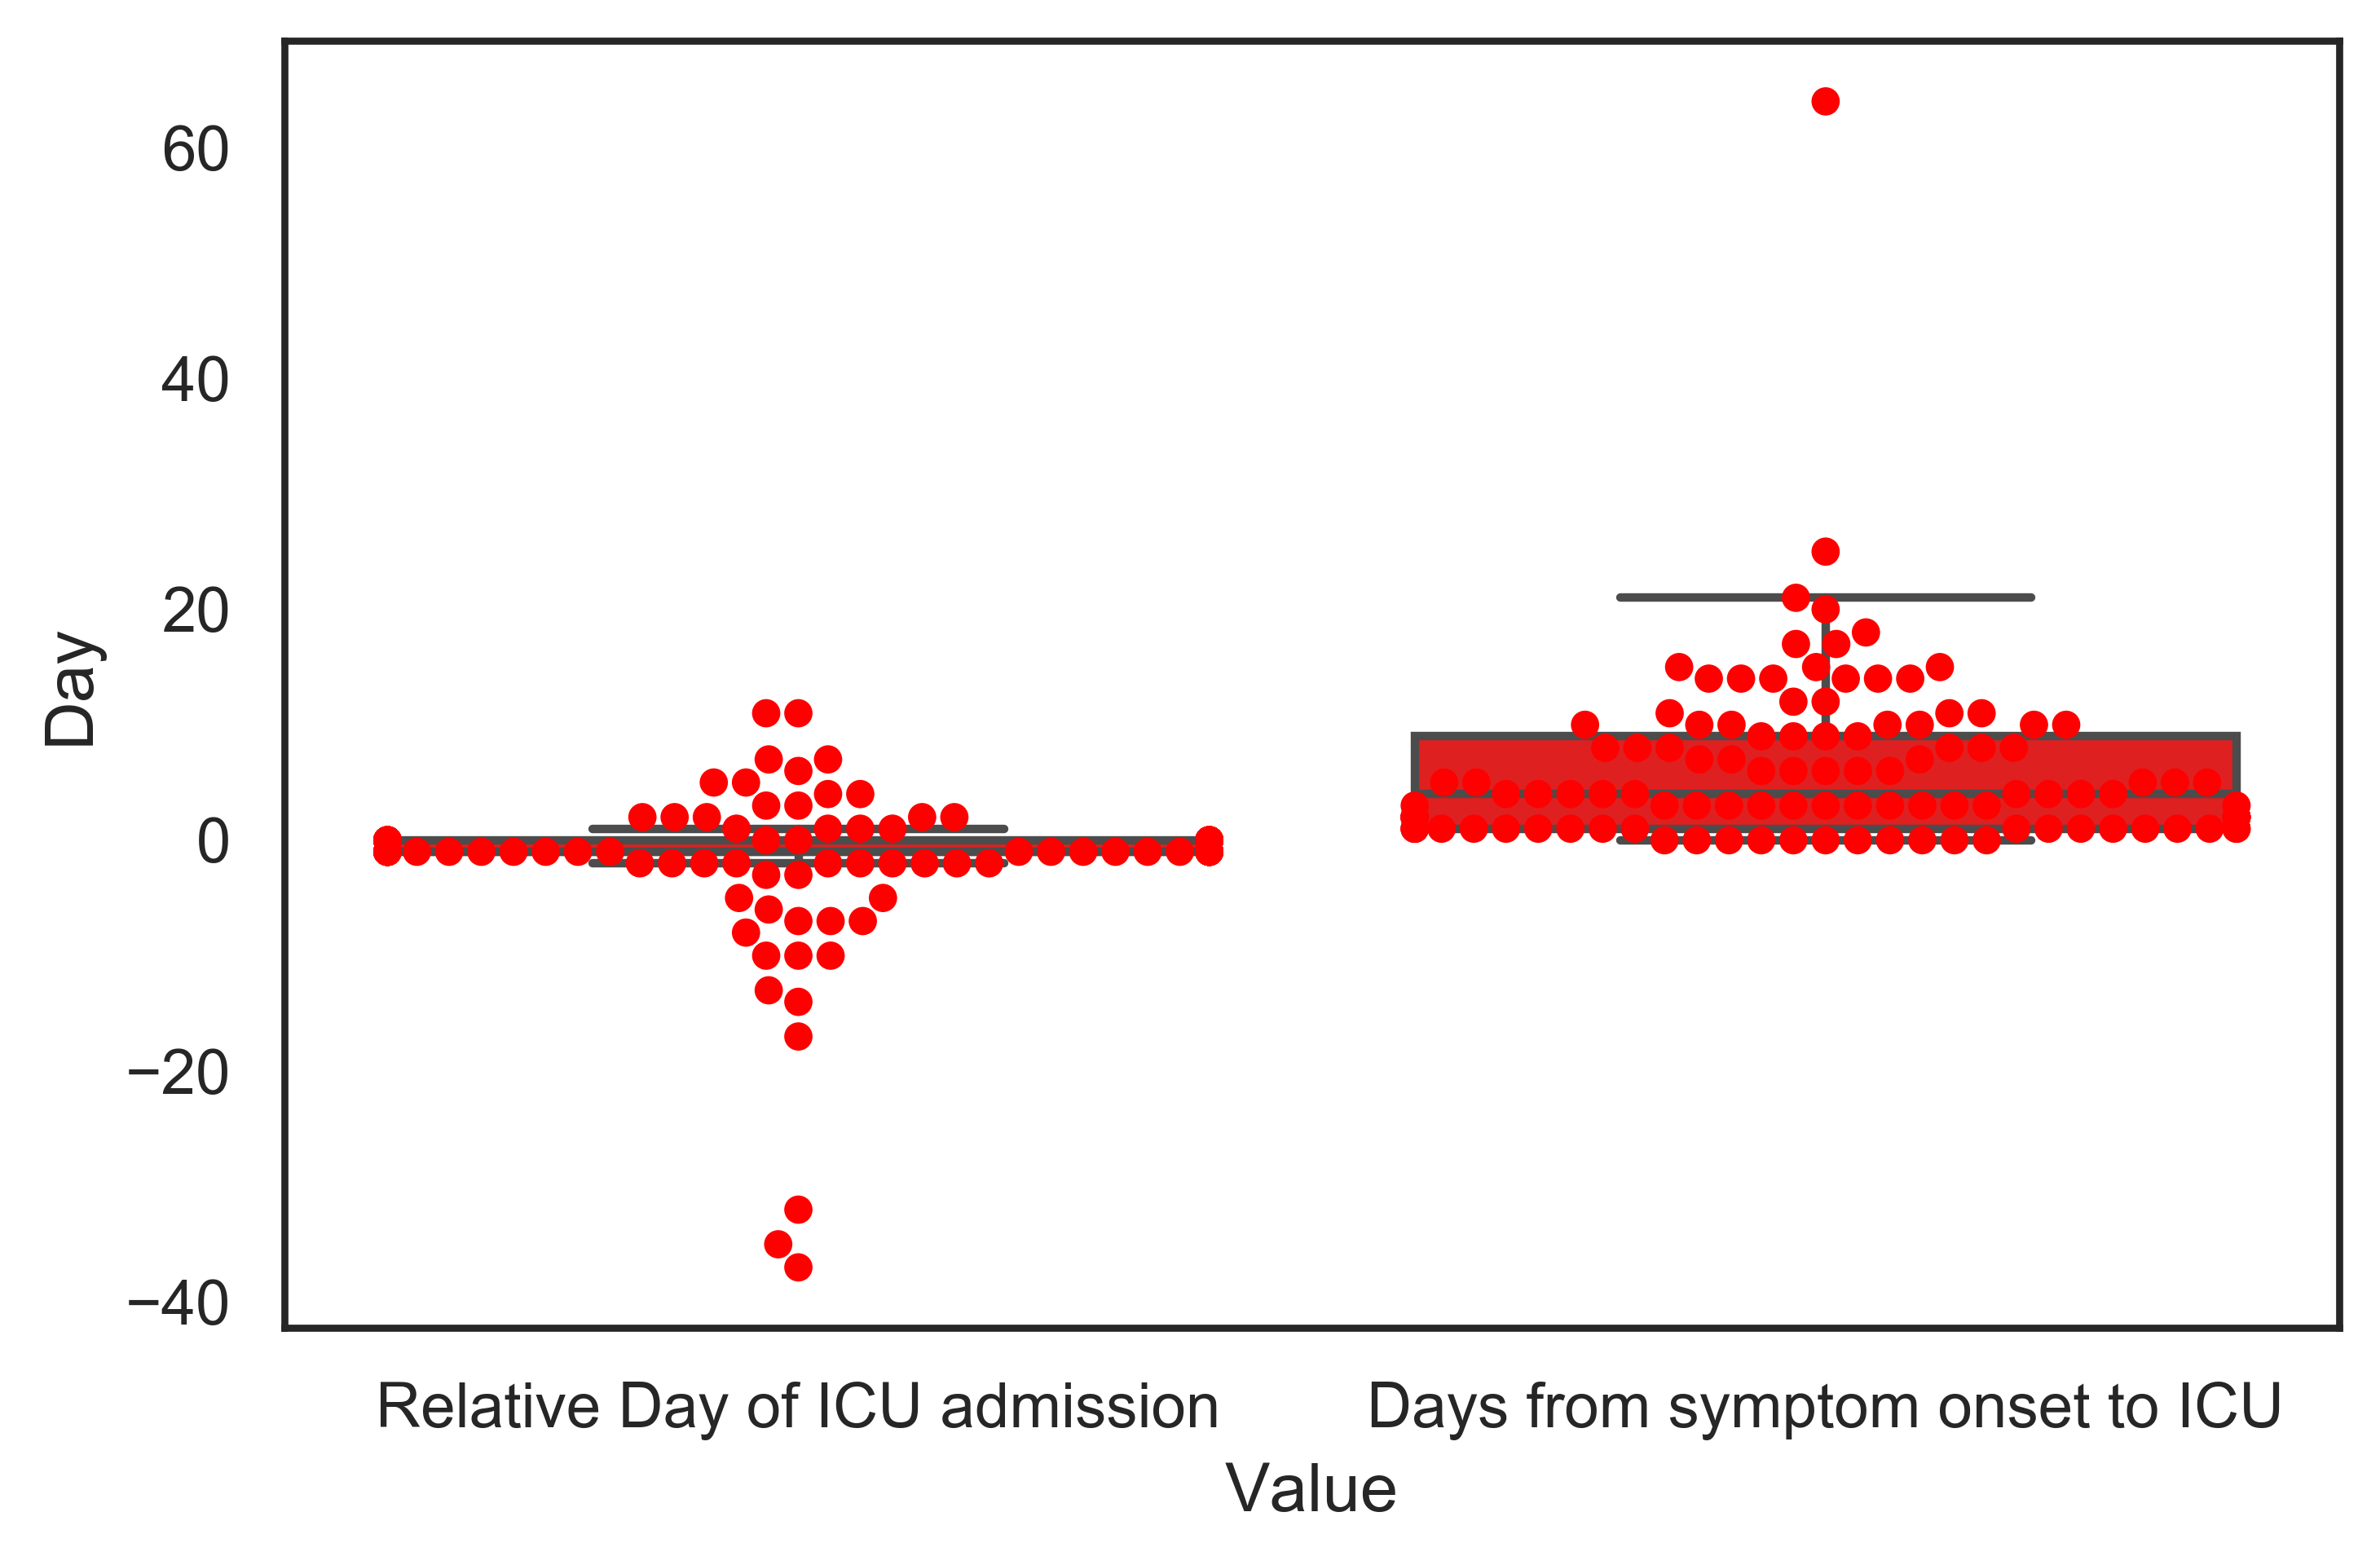

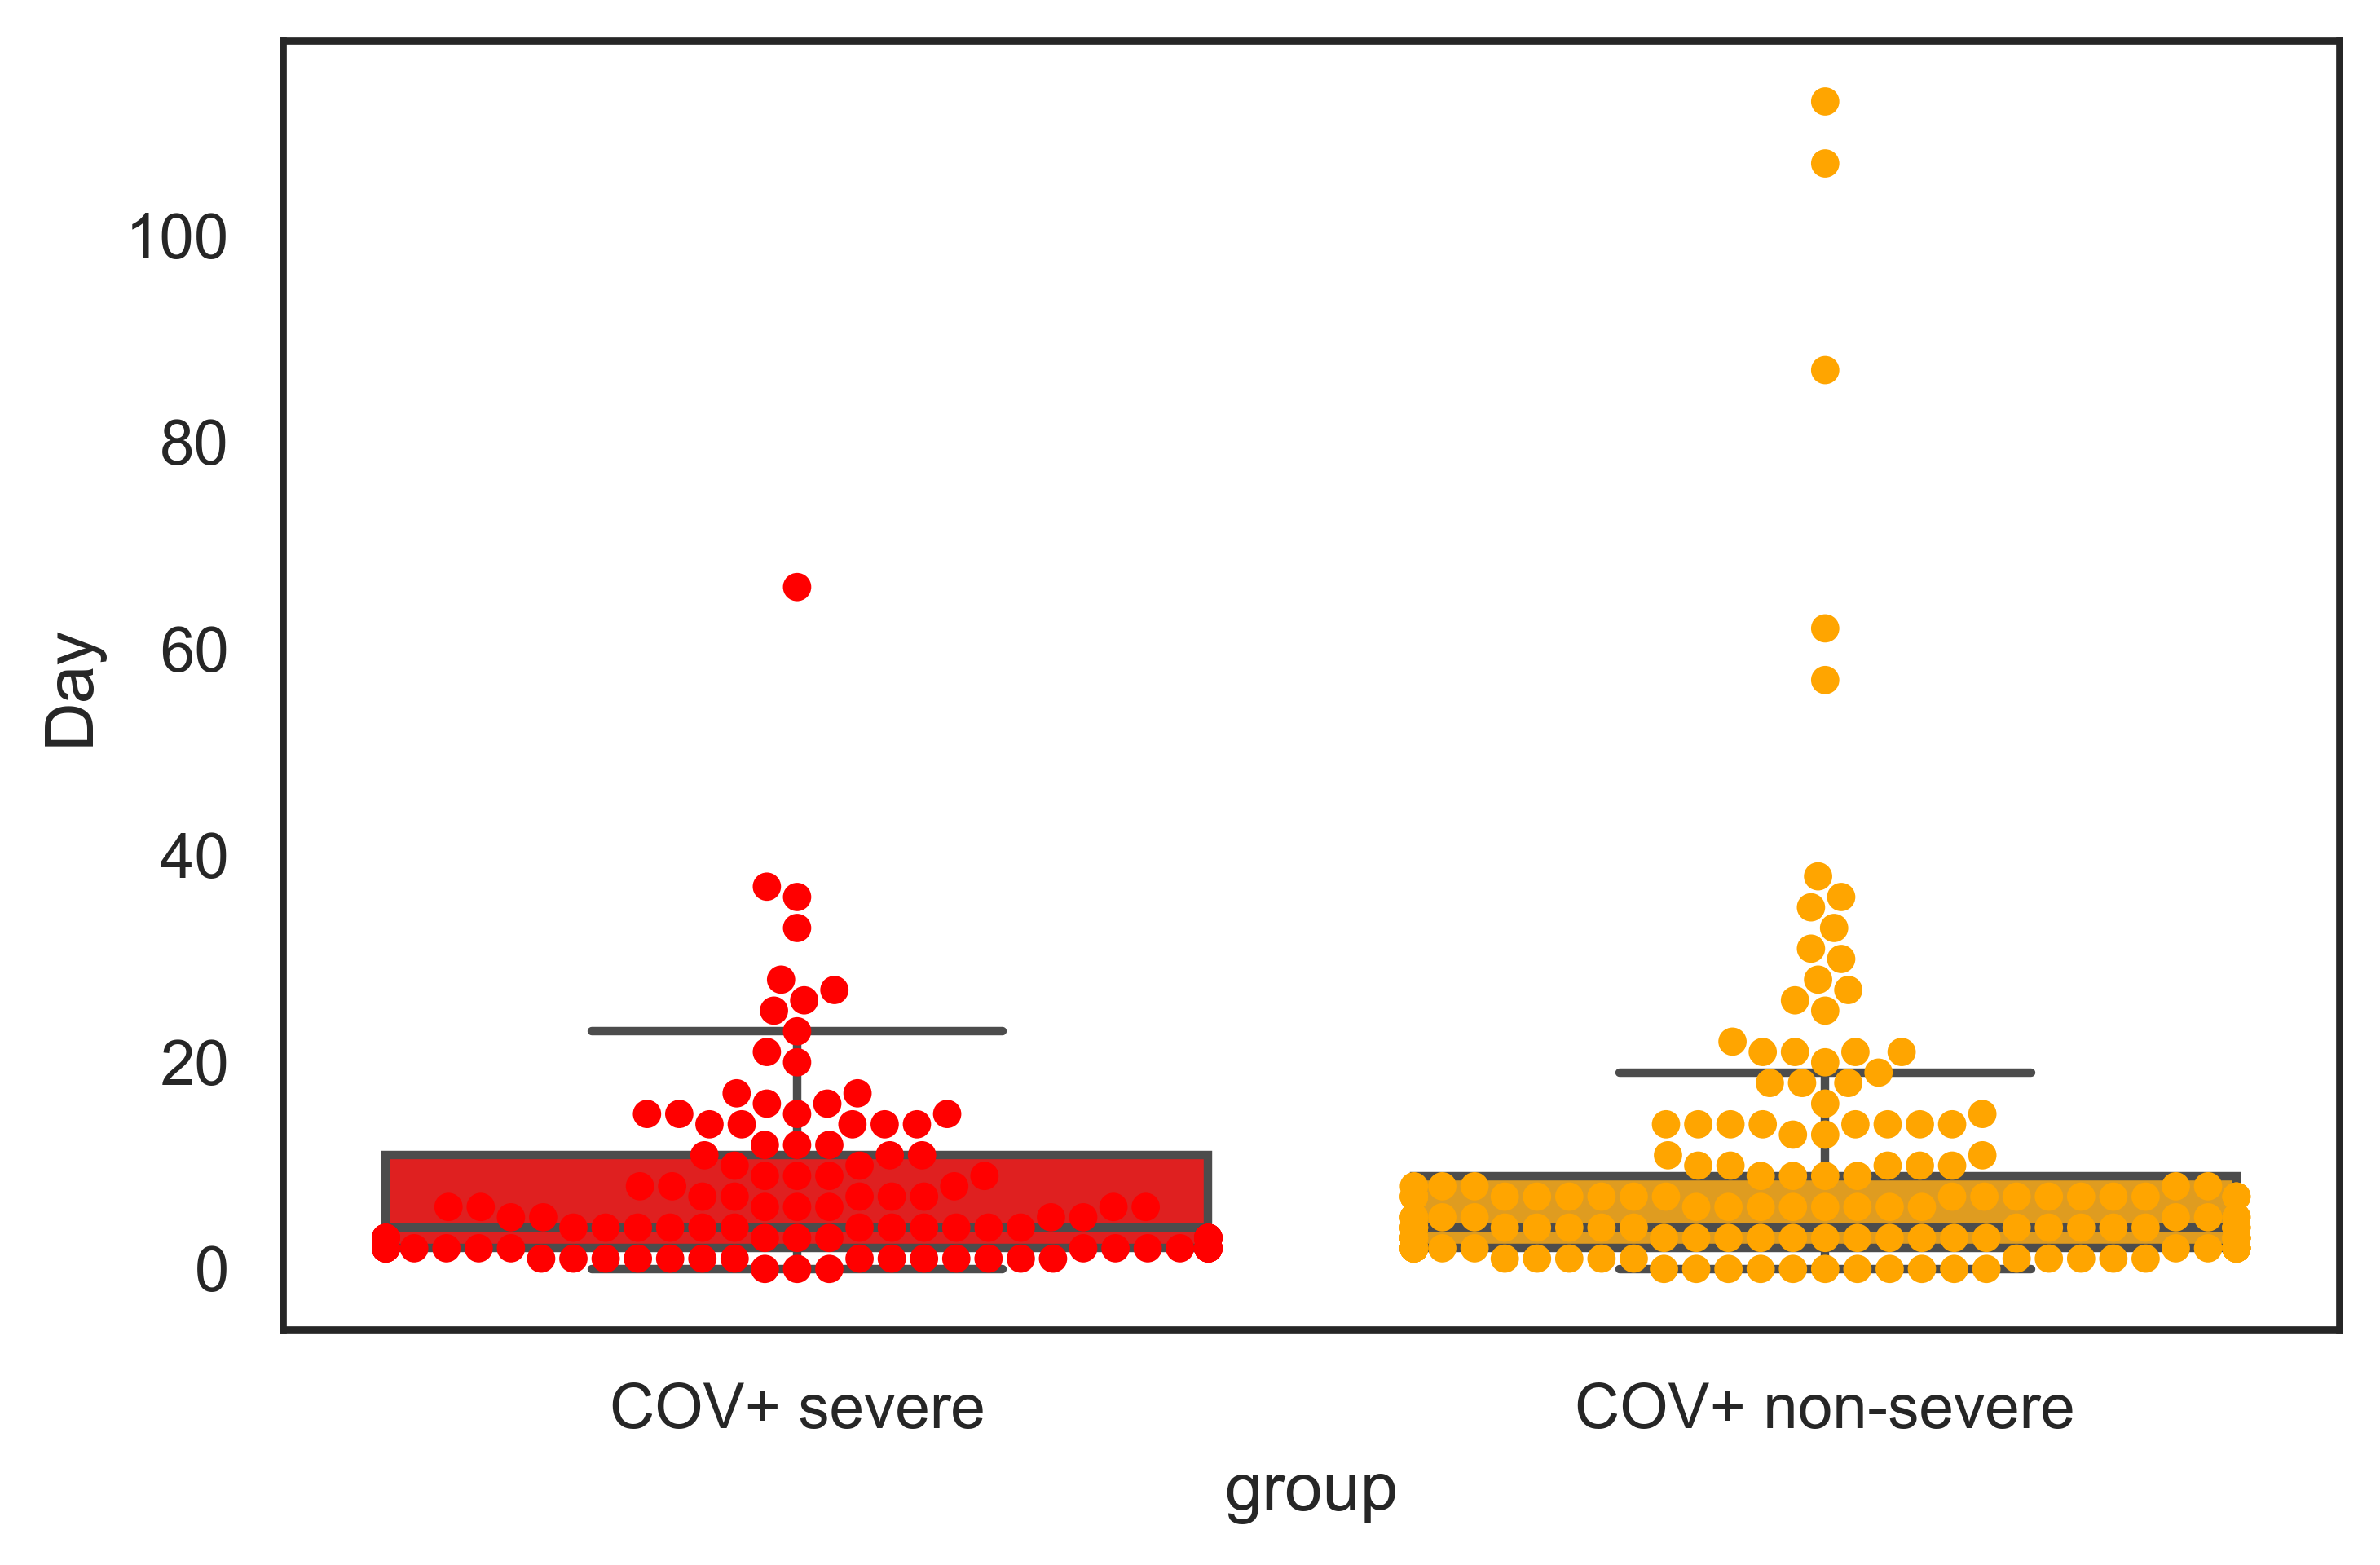

In [3]:
#split symponset into severe/non-severe change colors


icu_timings = []
symptom_onset = []
bad = 0
df = {}
ind = 0
icu_from_symptom = []
for patient,icu in patient_ICU.items():
    if icu > .5:
        x = metadata_for_samples[patient_ind[patient]]
        try:
            float(x["WU350-Symptom onset"])
            float(x["Epic: Time from symptom onset to ICU (days)"])
            if not np.isnan(float(x["WU350-Symptom onset"])) and not np.isnan(float(x["Epic: Time from symptom onset to ICU (days)"])):
                icu_timings.append(float(x["Epic: Time from symptom onset to ICU (days)"]) - float(x["WU350-Symptom onset"]))
                df[ind] = {}
                df[ind]["Value"] = "Relative Day of ICU admission"
                df[ind]["Day"] = float(x["Epic: Time from symptom onset to ICU (days)"]) - float(x["WU350-Symptom onset"])
                df[ind]["group"] = "COV+ severe"
                ind += 1
                df[ind] = {}
                df[ind]["Value"] = "Days from symptom onset to ICU"
                df[ind]["Day"] = float(x["Epic: Time from symptom onset to ICU (days)"])
                df[ind]["group"] = "COV+ severe"
                icu_from_symptom.append(float(x["Epic: Time from symptom onset to ICU (days)"]))
                ind += 1
            
        except:
            #print(x["WU350-Symptom onset"],x["Epic: Time from symptom onset to ICU (days)"])
            bad += 1
            pass
    x = metadata_for_samples[patient_ind[patient]]
    try:
        v = float(x["WU350-Symptom onset"])
        if not np.isnan(v):
            df[ind] = {}
            df[ind]["Value"] = "Days after symptom onset"
            df[ind]["Day"] = v
            if icu > .5:
                df[ind]["group"] = "COV+ severe"
            else:
                df[ind]["group"] = "COV+ non-severe"
            symptom_onset.append(v)
            ind += 1

    except:
        print(v)

    ind += 1

plt.figure()
print(np.median(symptom_onset),np.std(symptom_onset),len(symptom_onset),np.min(symptom_onset),np.max(symptom_onset))
print(np.mean(icu_timings),np.std(icu_timings),len(icu_timings))
print(np.mean(icu_from_symptom),np.std(icu_from_symptom),len(icu_from_symptom))

df = pd.DataFrame.from_dict(df,orient="index")
plt.figure()
sb.set(font_scale=1.0,font="Arial",style="white")

tmp = df[(df["Value"] == "Days from symptom onset to ICU") | (df["Value"] == "Relative Day of ICU admission")]

sb.boxplot(data=tmp,x="Value",y="Day",fliersize=0,palette= {"Days from symptom onset to ICU":"red","Relative Day of ICU admission":"red"})
sb.swarmplot(data=tmp,x="Value",y="Day", dodge=True,palette= {"Days from symptom onset to ICU":"red","Relative Day of ICU admission":"red"})
plt.tight_layout()
plt.savefig("../manuscript_figs/dayOfICU.png")
plt.figure()

tmp = df[(df["Value"] == "Days after symptom onset")]
sb.boxplot(data=tmp,x="group",y="Day",fliersize=0,palette= {"COV+ severe":"red","COV+ non-severe":"orange"})
sb.swarmplot(data=tmp,x="group",y="Day", dodge=True,palette= {"COV+ severe":"red","COV+ non-severe":"orange"})
plt.tight_layout()
plt.savefig("../manuscript_figs/dayOfSymptomOnset.png")
print(stats.ttest_ind(tmp[tmp["group"] == "COV+ non-severe"]["Day"].values,tmp[tmp["group"] == "COV+ severe"]["Day"].values,equal_var=False))


#print(len(df[(df["Value"] == "Relative Day of ICU admission") & (df["Day"] <=0)]))

In [6]:
measurement_data = pd.read_csv("../data/PMN_CRP_d-dimer_CO2_Comorbidities_updated_all_data_rel_cyto_new_comorb_6_23_21.csv",index_col=0)
print(measurement_data.columns.values)
goodCols = list(measurement_data.columns.values)[:16] + list(measurement_data.columns.values)[-14:] + ["Any drug"]
measurement_data = measurement_data[goodCols]
measurement_data
good = 0
for x in measurement_data["IL6"]:
    if not pd.isna(x):
        if type(x) == type(""):
            x = x.replace("<","").replace(">","")
        x = float(x)
        if x >= 0:
            good += 1
print(good)

['CRP' 'D-dimer' 'Neutrophil %' 'CO2' 'Acute respiratory failure'
 'Diabetes' 'Acute renal failure' 'Chronic kidney disease' 'Cancer' 'BMI'
 'Age' 'Smoker' 'High/Low arterial pH' 'Neutrophil absolute'
 'Lymphocyte absolute' 'Lymphocyte %' 'Hydroxychloroquine' 'Chloroquine'
 'Azithromycin' 'Remdesivir' 'Dexamethasone' 'Ravulizumab' 'Any drug'
 'IL1b' 'IL10' 'IL6' 'RANTES' 'MIP1a' 'GMCSF' 'MCP1' 'IL15' 'HGF' 'VEGF'
 'IL1Ra' 'IL2R' 'MIG' 'IL8']
151


13743.479980450073

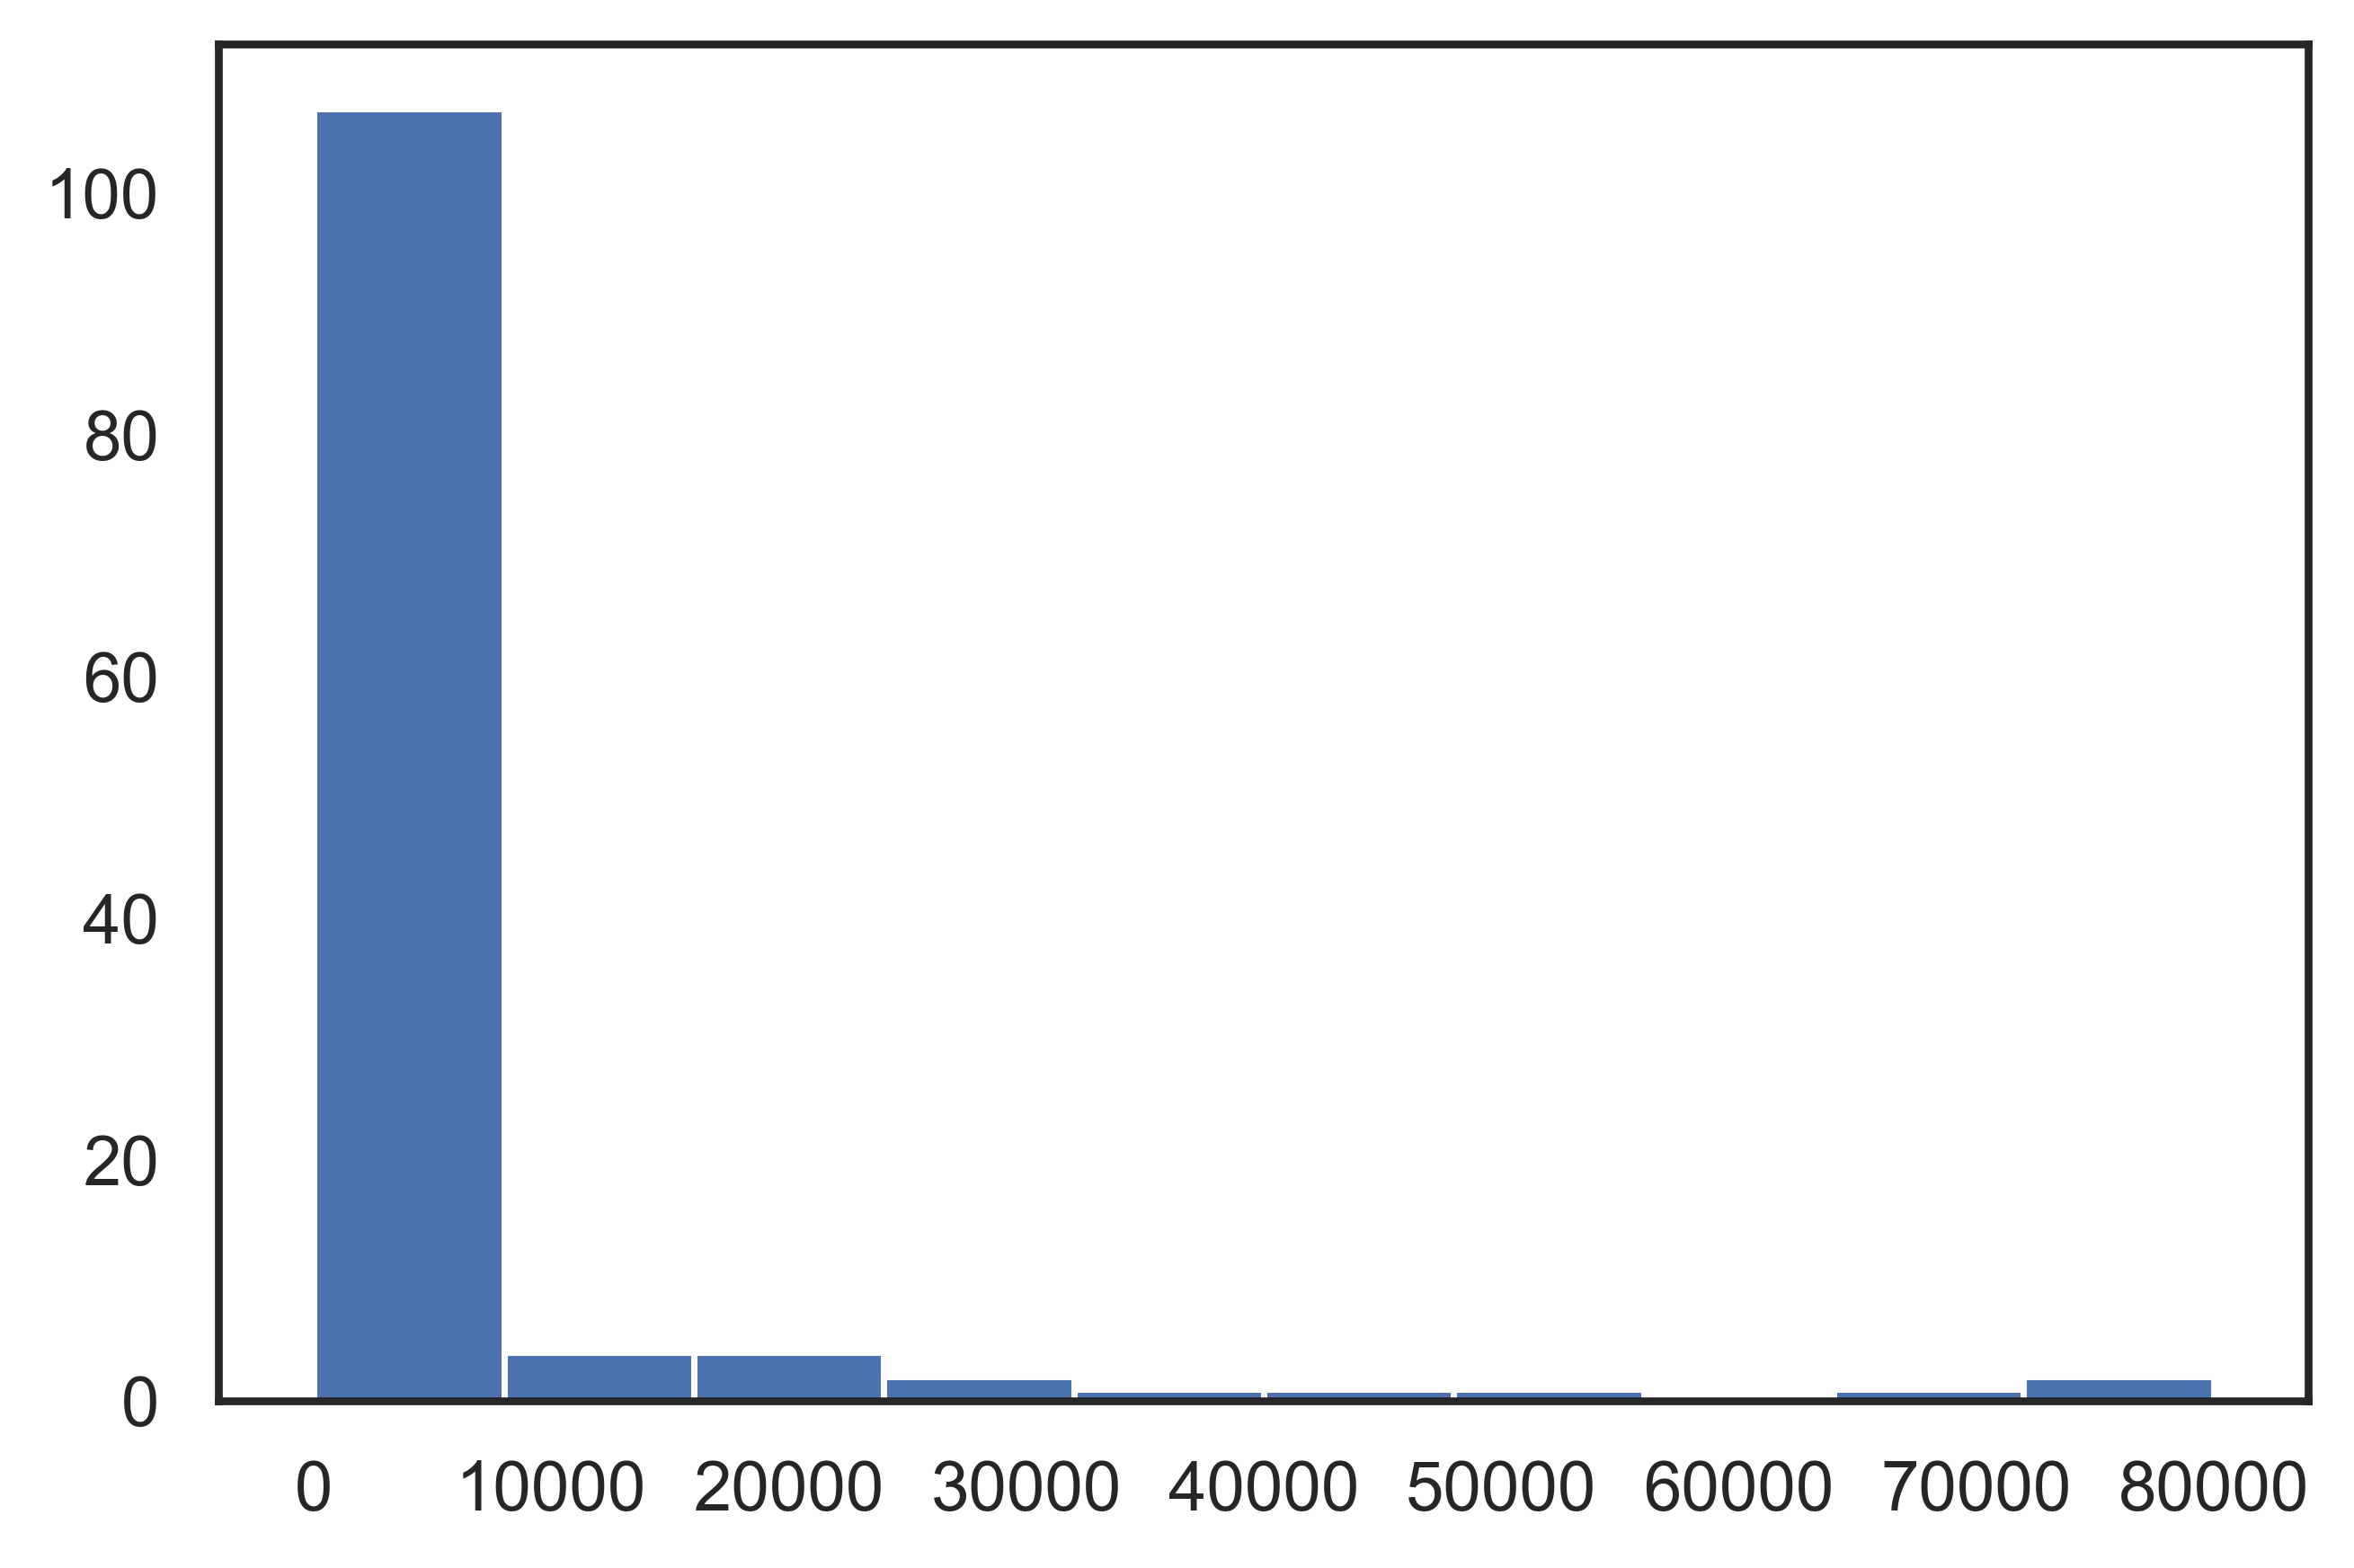

In [7]:
plt.hist([float(row["D-dimer"].replace(">","")) for index,row in measurement_data.iterrows() if row["D-dimer"] != -1 and index in patient_ICU and patient_ICU[index] > .5])
np.std([float(row["D-dimer"].replace(">","")) for index,row in measurement_data.iterrows() if row["D-dimer"] != -1 and index in patient_ICU and patient_ICU[index] > .5])

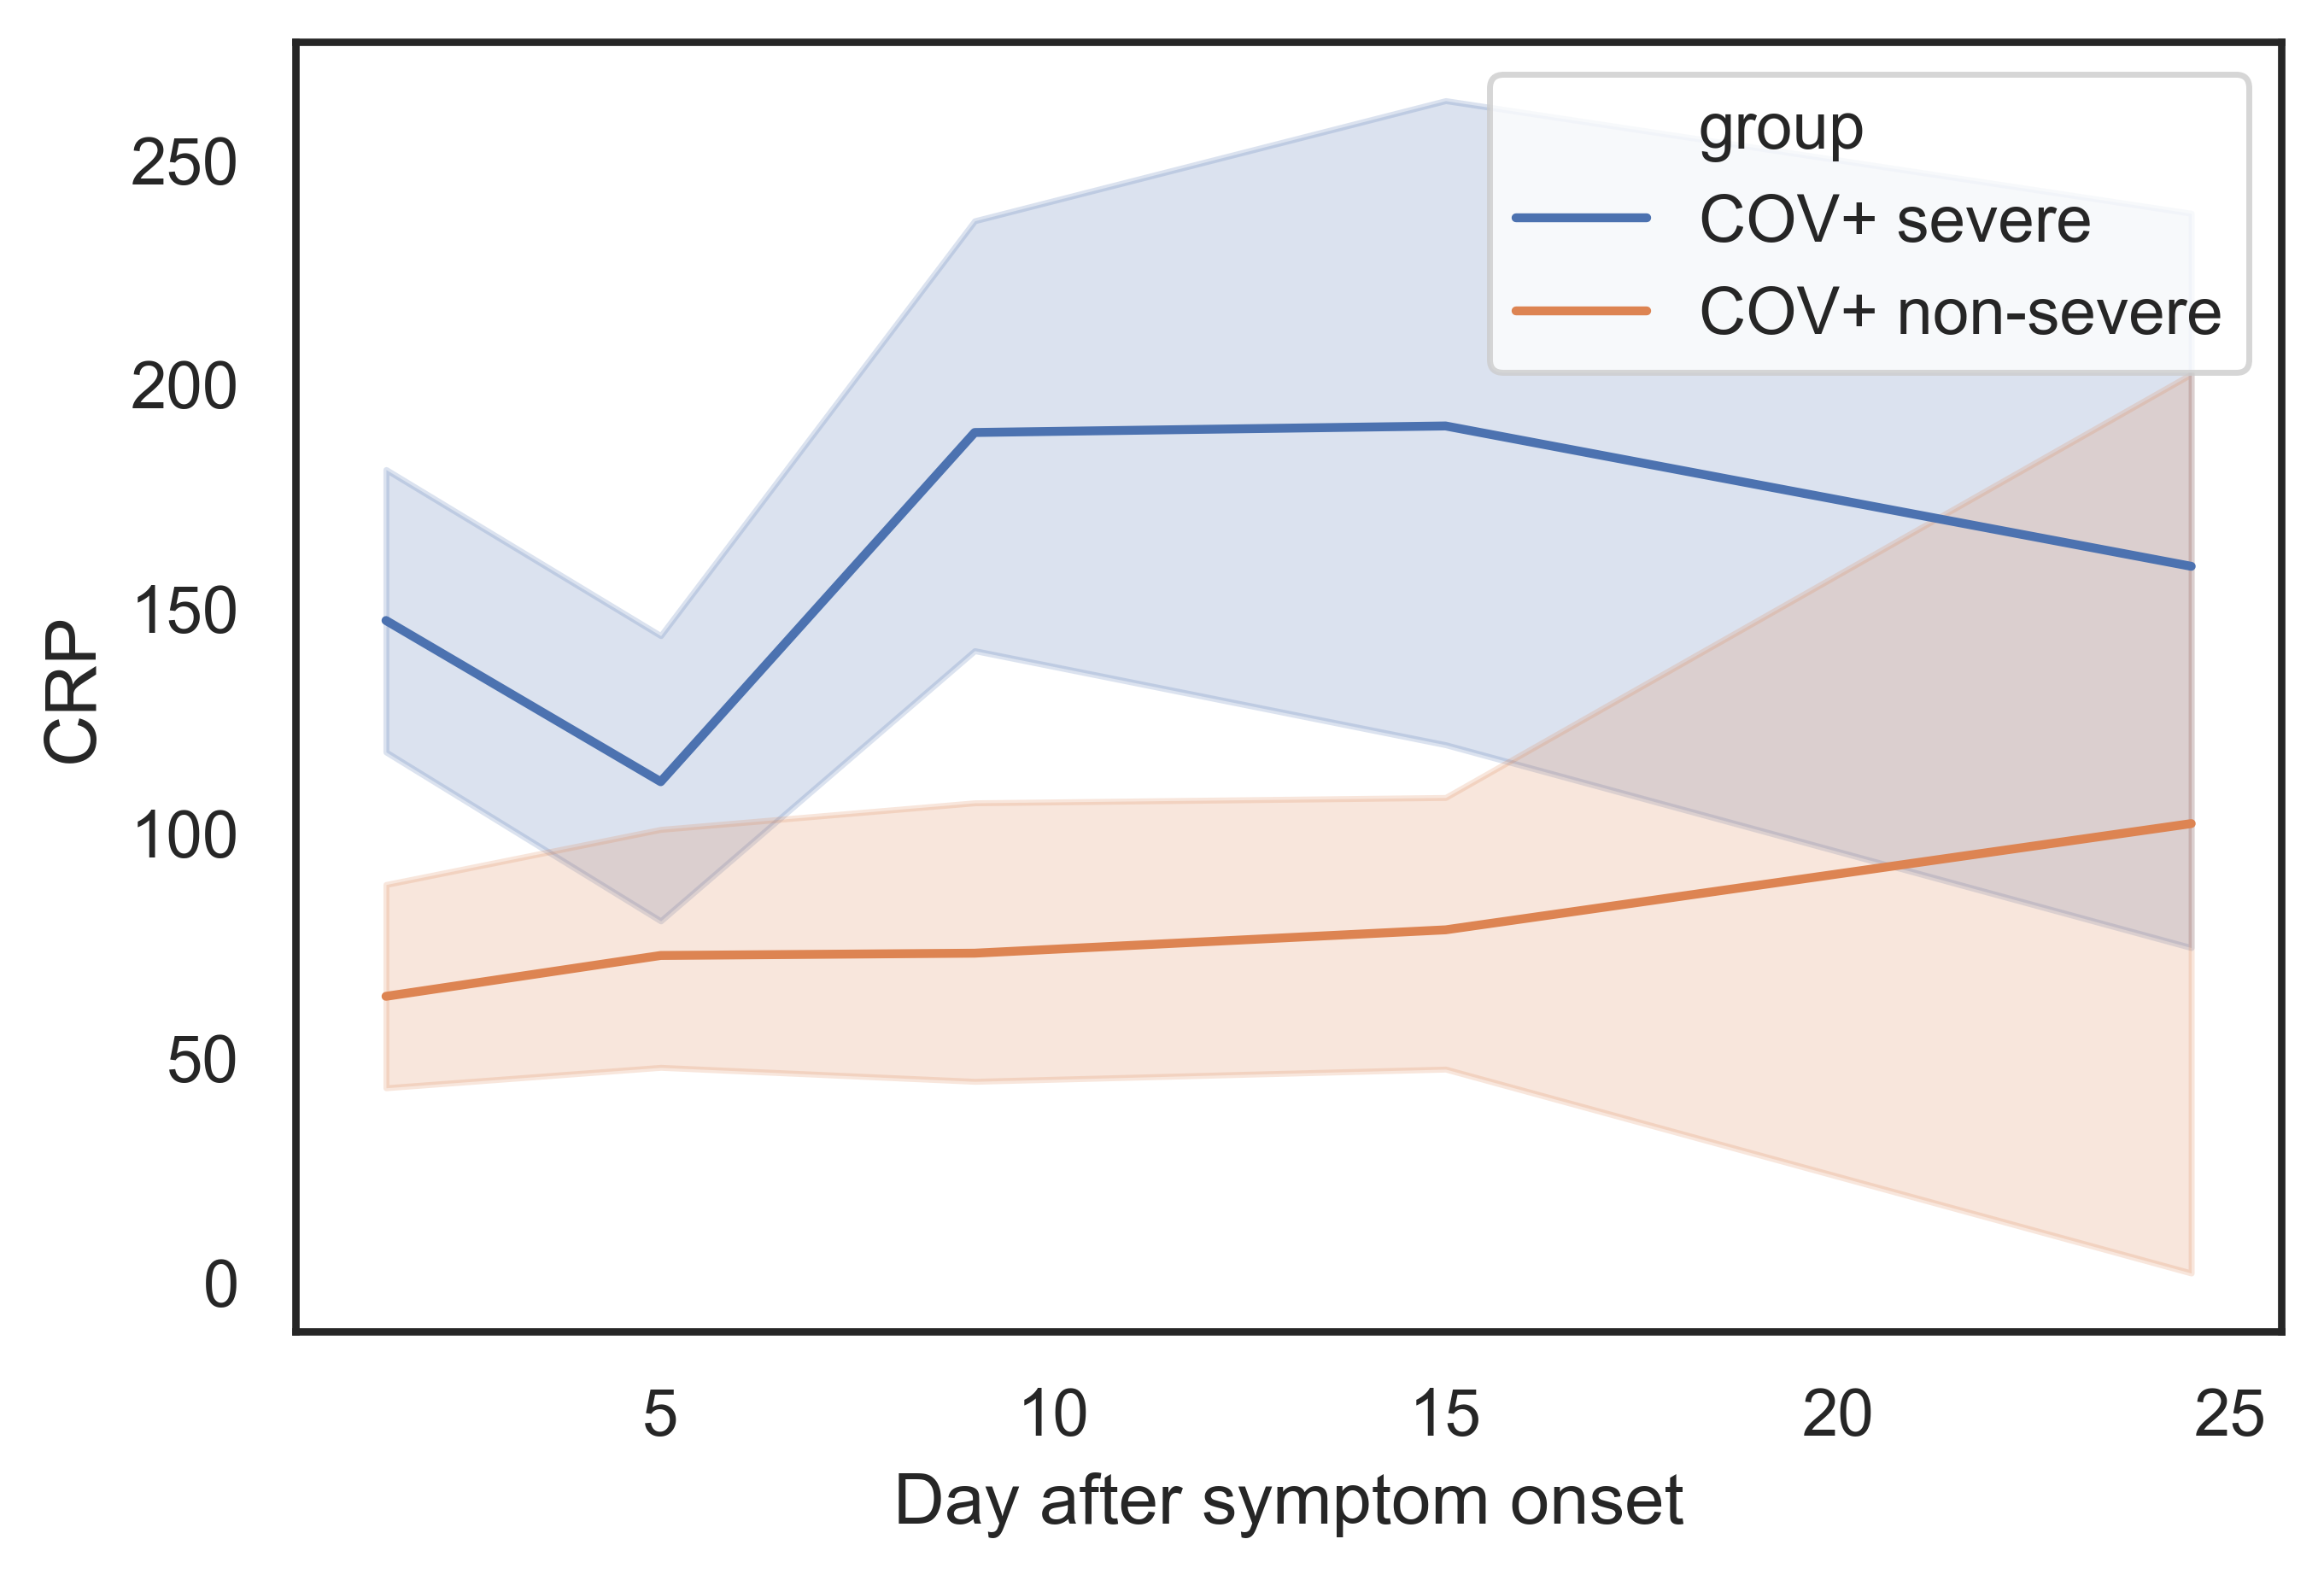

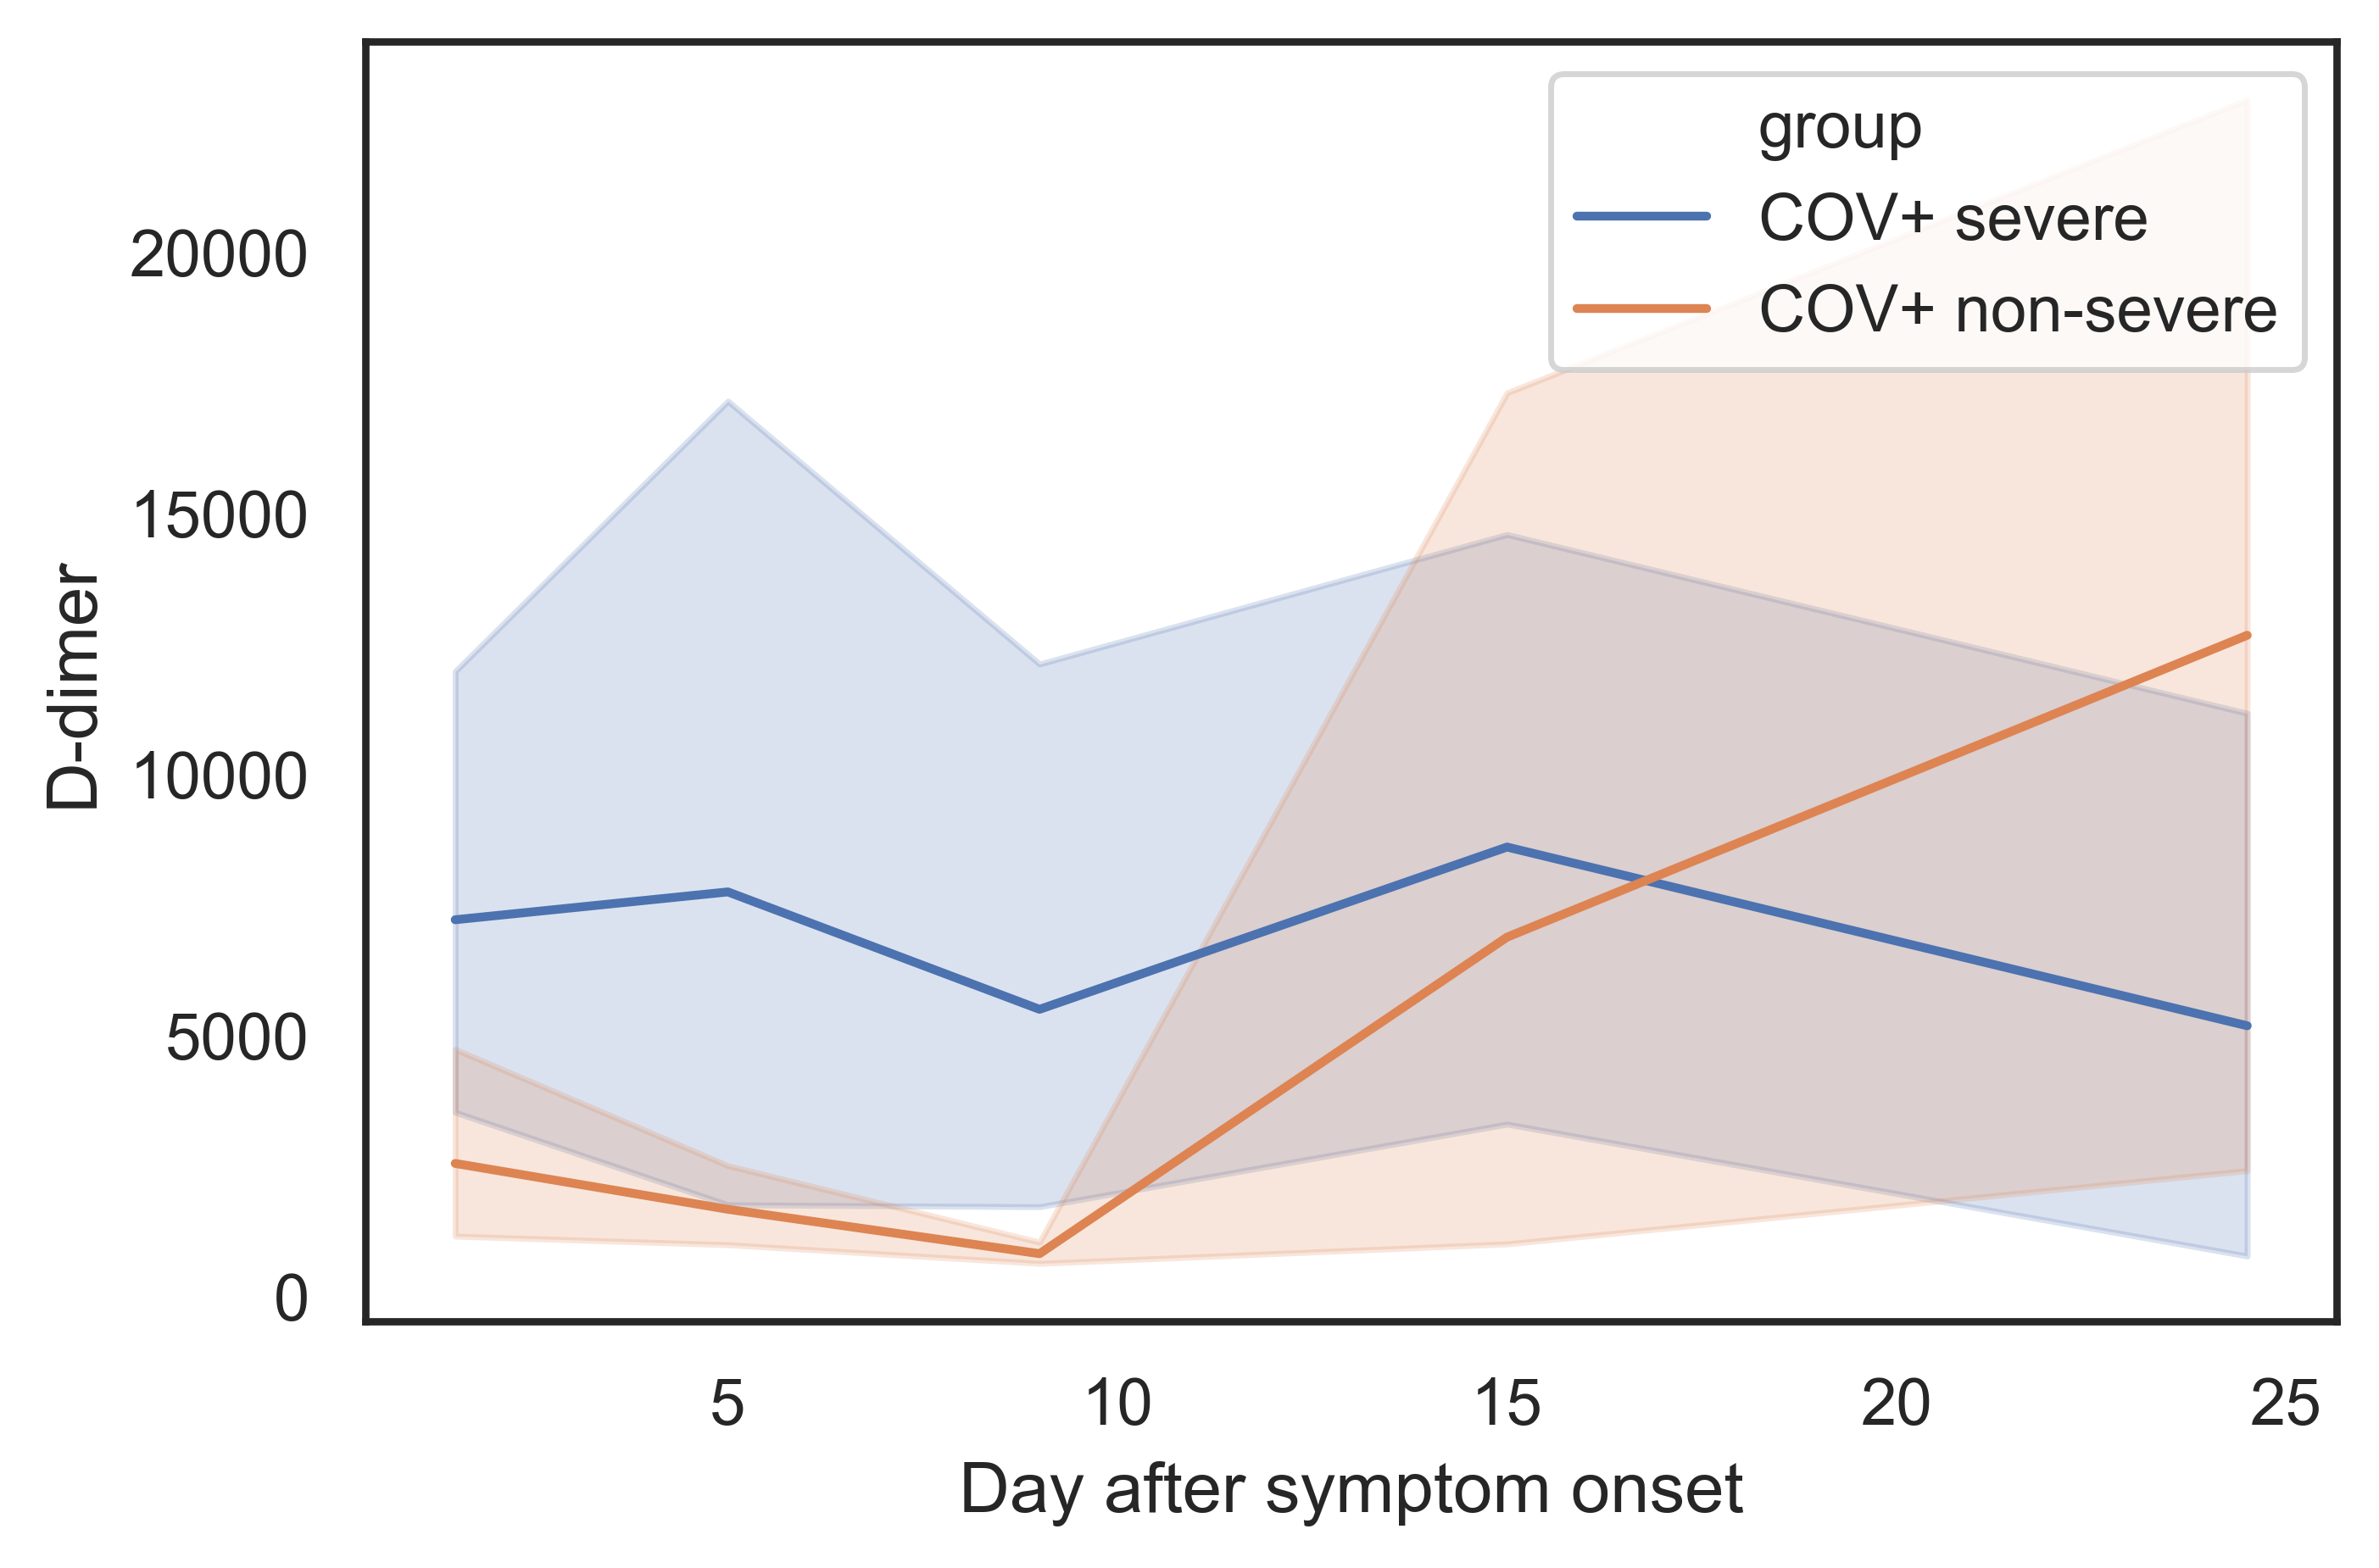

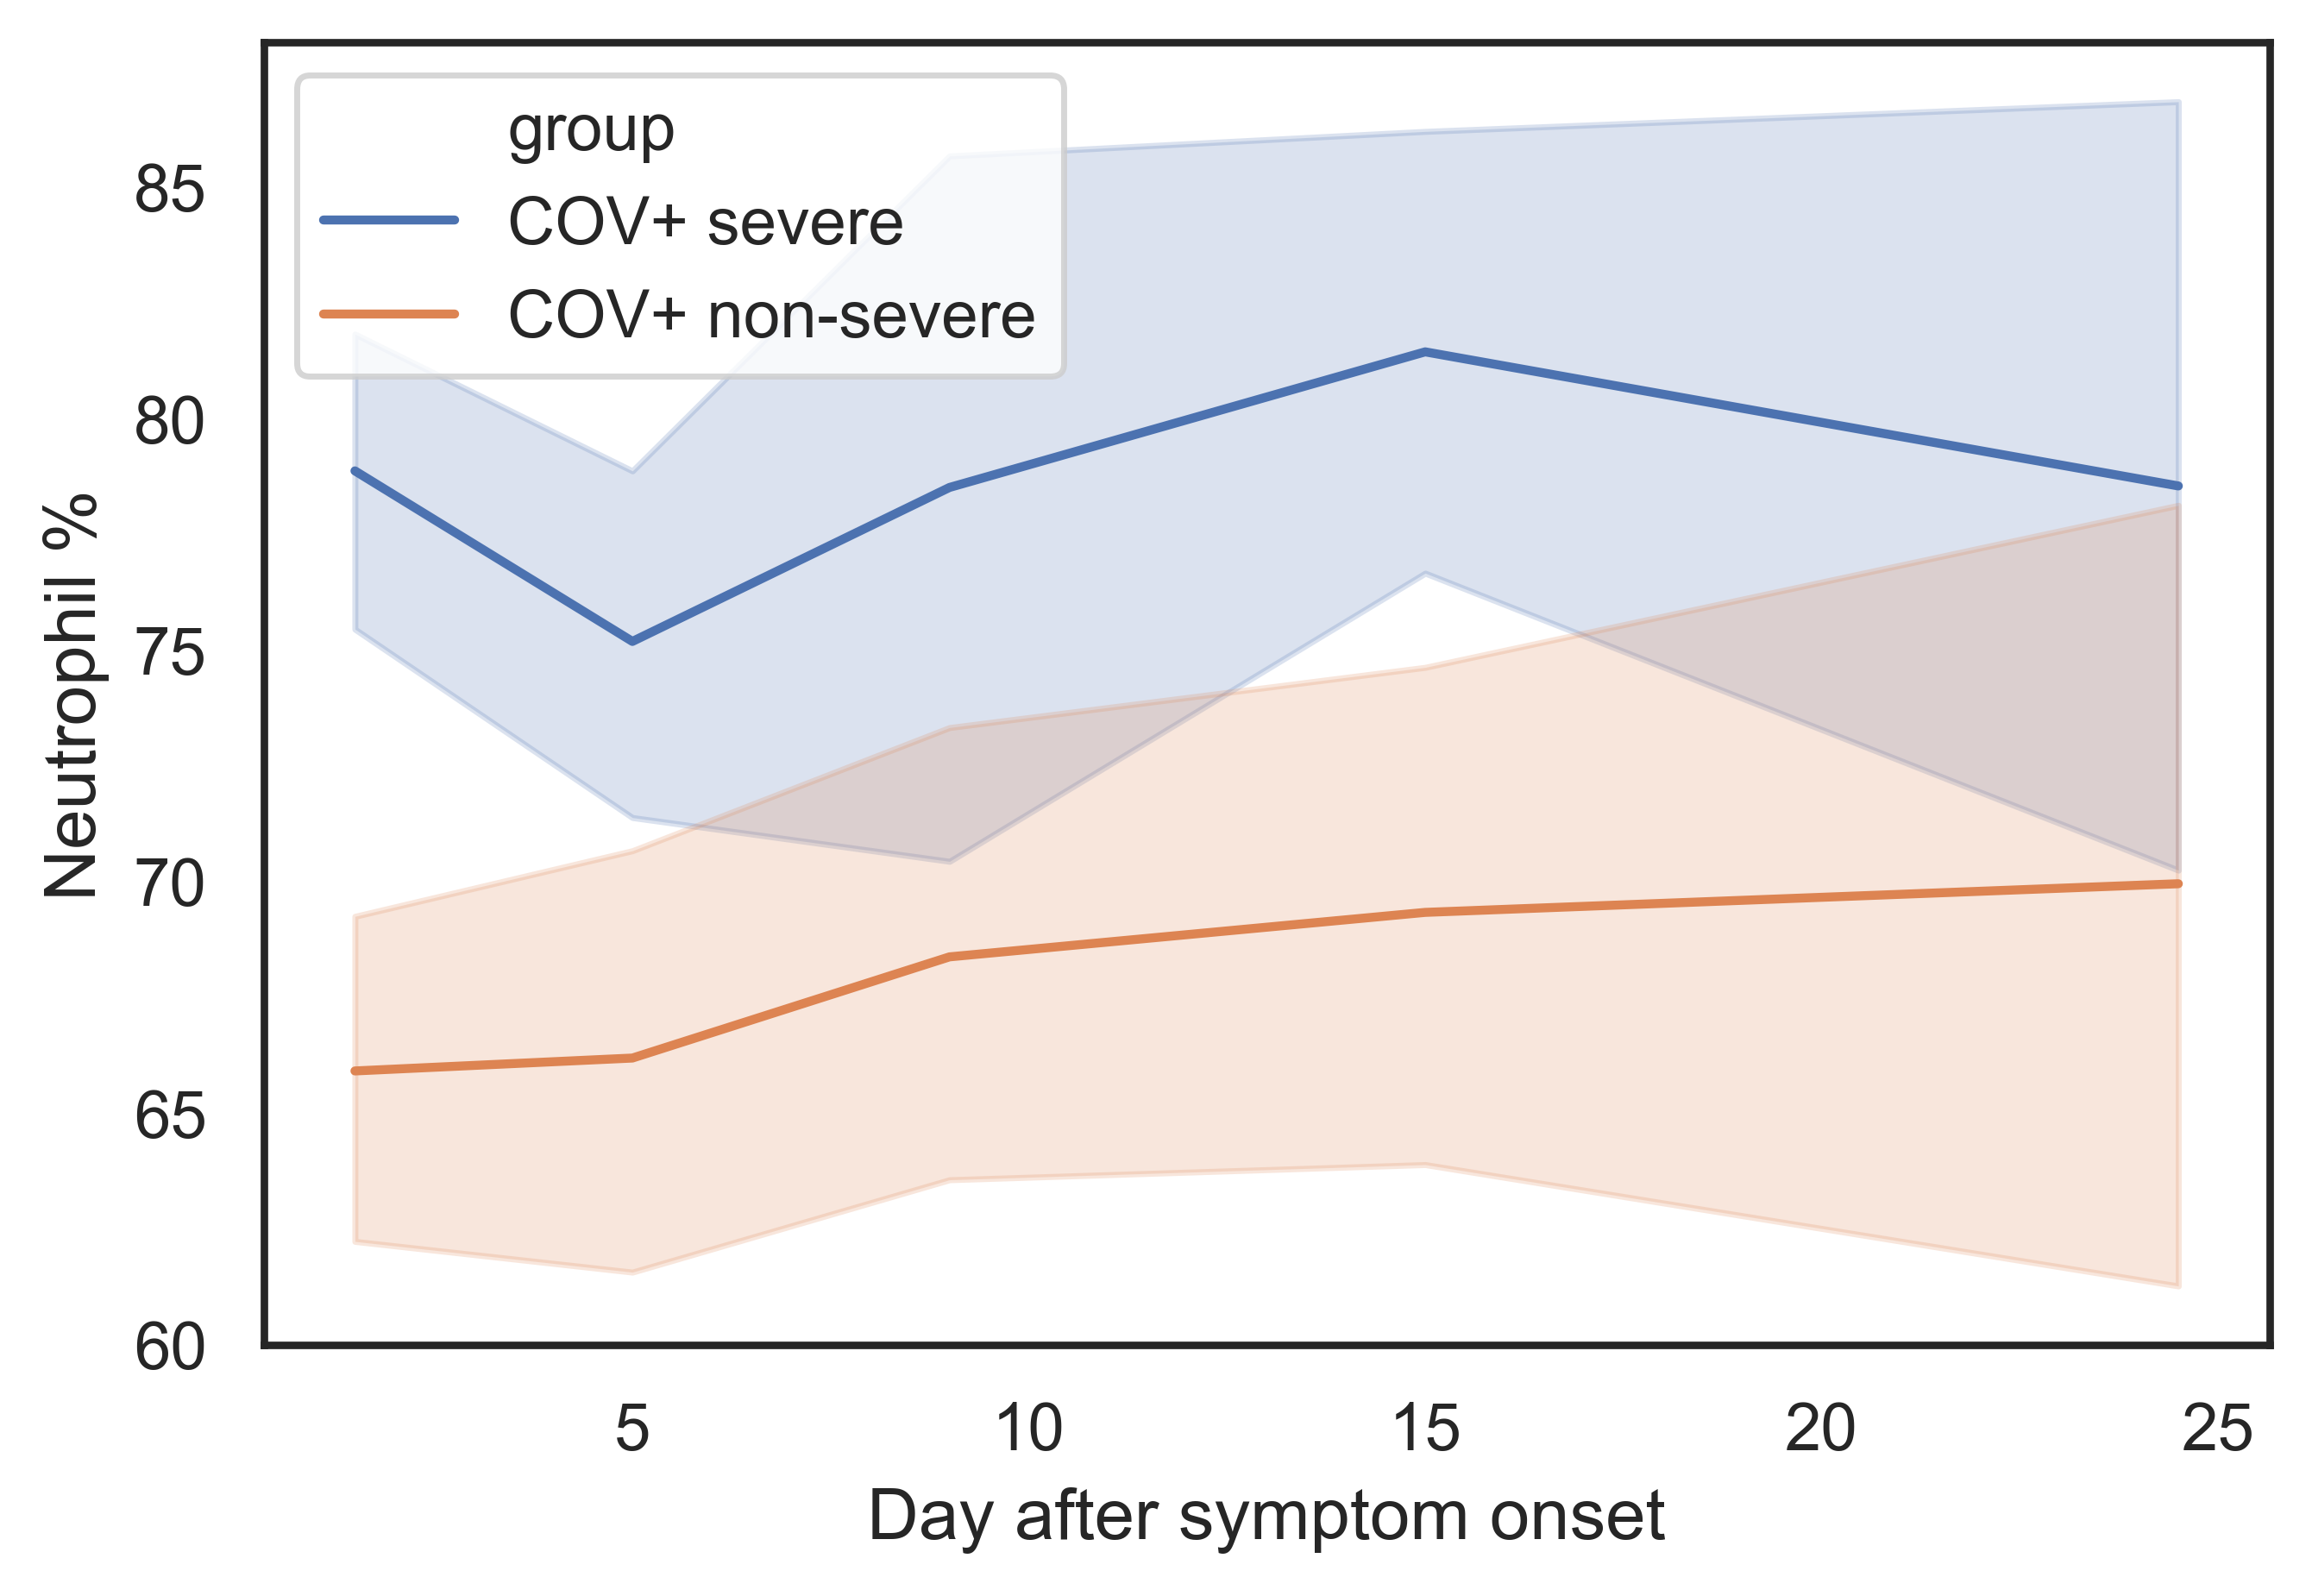

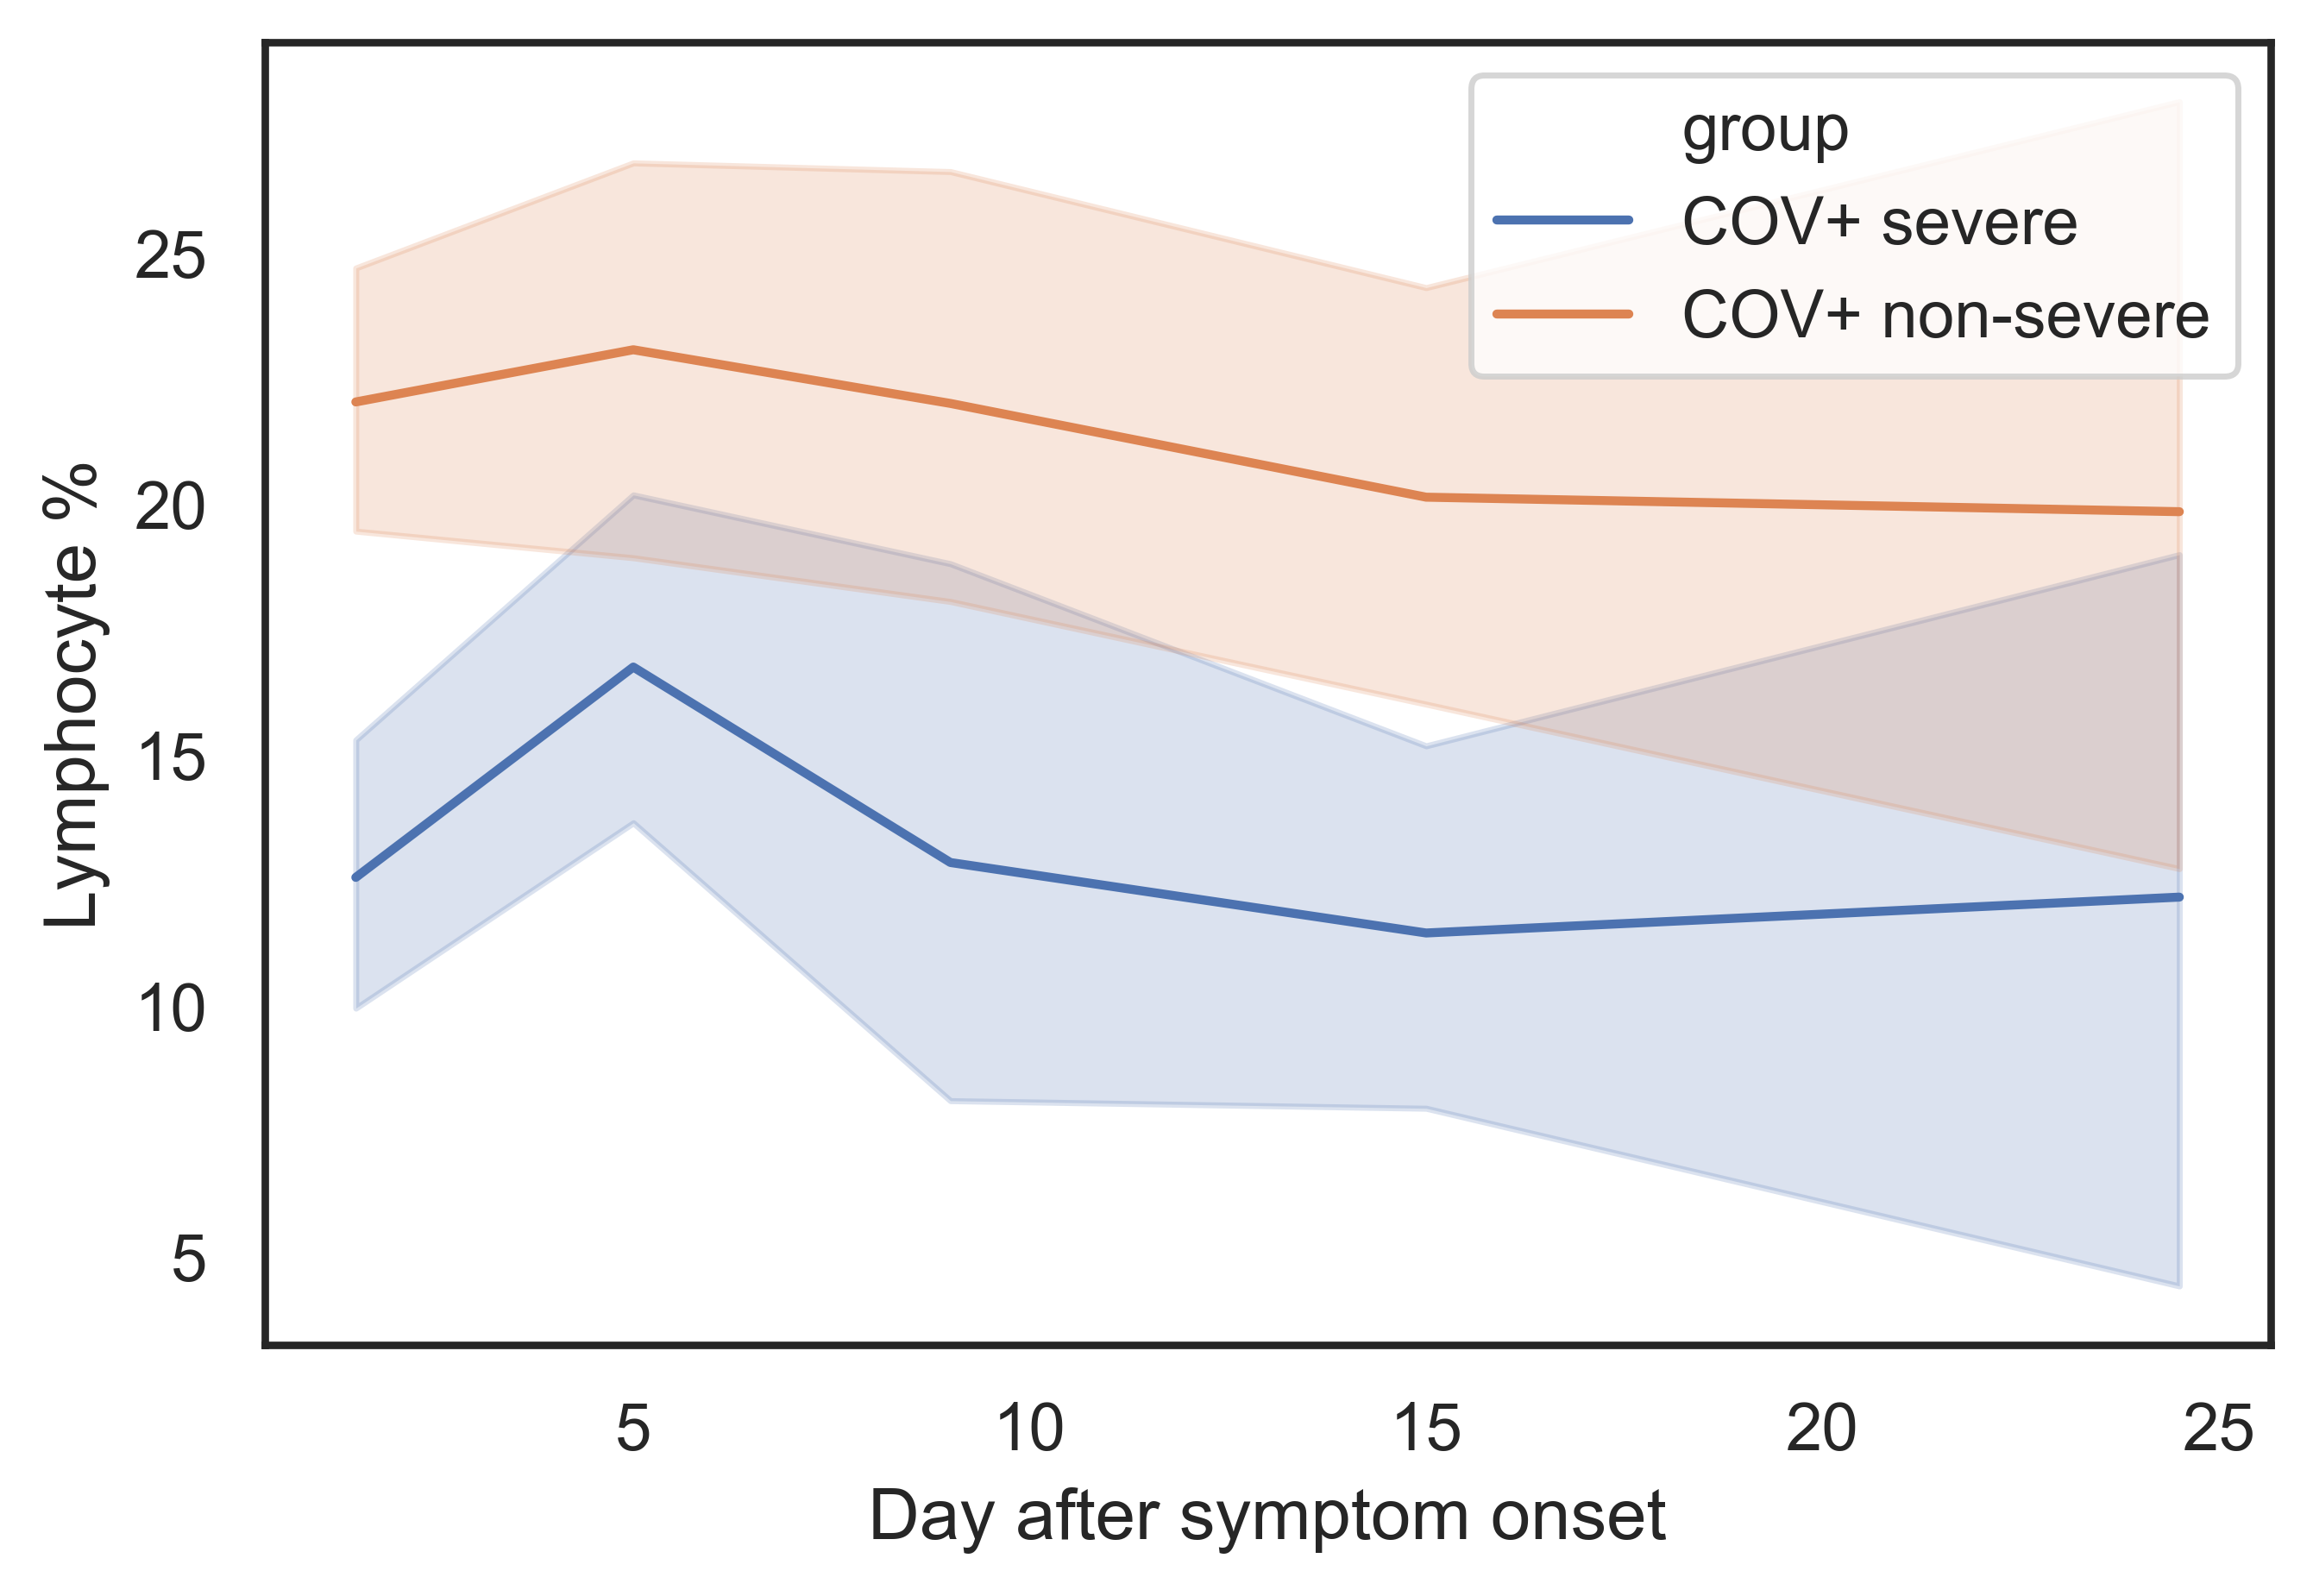

In [8]:
days = [[0,3],[4,6],[7,11],[12,18],[19,30]]
def getClosestDay(day,days):
    #return day
    for d in days:
        if day >= d[0] and day <= d[1]:
            return d
    return d

for col in ['CRP' ,'D-dimer', 'Neutrophil %',"Lymphocyte %"]:
    plotter = {}
    for pat in patient_ids:
        switcher = {-1:"COV-",0:"COV+ non-severe",1:"COV+ severe"}
        if patient_ICU[pat] > -.5:
            group = switcher[patient_ICU[pat]]
            lev = measurement_data.at[pat,col]
            x = metadata_for_samples[patient_ind[pat]]
            day = x["WU350-Symptom onset"]

            if not pd.isna(day):
                day = float(day)
                if not pd.isna(lev):
                    if type(lev) == type(""):
                        lev = lev.replace("<","").replace(">","")
                    if float(float(lev)) > -.5:
                        lev = float(lev)
                        if day < 30:
                            plotter[len(plotter)] = {"group":group,col:lev,"Day after symptom onset":np.mean(getClosestDay(day,days))}

    plotter = pd.DataFrame.from_dict(plotter,orient="index")
    plt.figure()
    sb.lineplot(data=plotter,x="Day after symptom onset",y=col,hue="group")








In [9]:
to_drop = []
for index,row in measurement_data.iterrows():
    if index not in patient_ids:
        to_drop.append(index)
measurement_data = measurement_data.drop(to_drop)

df = measurement_data




In [10]:
correlative_df = {mol:{fact:-1 for fact in list(measurement_data.columns.values) if fact != "Any drug"} for mol in mol_names}
pval_df = {mol:{fact:-1 for fact in list(measurement_data.columns.values) if fact != "Any drug"} for mol in mol_names}
icu2Include = [1,0,-1]
for col in measurement_data.columns.values:
    if col != "Any drug":
        for met in range(len(mol_names)):
            plot_df = {}
            val = samp_int[:,met]
            val_normer = {}
            #for icu in icu2Include:
            #    for x,pat in zip(val,patient_ids):
            index = 0
            for x,pat in zip(val,patient_ids):
                if pat in list(df.index.values) and patient_ICU[pat] in icu2Include:
                    comorb = df.at[pat,col]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            if col in ["IL1b","IL10","IL6","RANTES","MIP1a","GMCSF","MCP1","IL15","HGF","VEGF","IL1Ra",
                                       "IL2R","MIG","IL8"]: comorb = np.log2(float(comorb))
                            plot_df[index] = {col:float(comorb),"Intensity":x}
                            index += 1

            plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
            r,p = stats.pearsonr(plot_df[col].values,plot_df["Intensity"].values)
            print(r,col)#,plot_df[col].values,plot_df["Intensity"].values)
            correlative_df[mol_names[met]][col] = r
            pval_df[mol_names[met]][col] = p



            





0.4736343180494445 CRP
0.31893301020562514 CRP
-0.3948357787859413 CRP
-0.4084275508047686 CRP
-0.410425481797422 CRP
-0.3549488844648353 CRP
-0.32896703252165144 CRP
-0.3946742181791407 CRP
-0.35288409158516604 CRP
-0.36095184649703665 CRP
-0.3805061788242054 CRP
-0.33996982908512813 CRP
-0.3555864297456596 CRP
-0.35871705146681004 CRP
-0.3405670681443926 CRP
-0.3467332410570935 CRP
-0.2912612802705708 CRP
0.42334637002547254 CRP
0.30354244698117094 CRP
-0.3911341645188513 CRP
0.28029621122286347 CRP
0.14209800939930523 CRP
-0.06435787470921449 D-dimer
-0.020458841039543416 D-dimer
-0.13620628132380463 D-dimer
-0.1384062946250913 D-dimer
-0.10292965100352364 D-dimer
-0.11536004018201912 D-dimer
-0.06941071050661073 D-dimer
-0.10423789898047296 D-dimer
-0.12084950221663705 D-dimer
-0.10753155808453142 D-dimer
-0.09042291361823676 D-dimer
-0.10480847051536328 D-dimer
-0.058004936381011896 D-dimer
-0.07766650499302902 D-dimer
-0.12409417146504416 D-dimer
-0.12499284507561689 D-dimer
-0.0

-0.28280829336265384 High/Low arterial pH
-0.2381744766089917 High/Low arterial pH
0.2719399349730467 High/Low arterial pH
0.23033784792284612 High/Low arterial pH
-0.3162742850321118 High/Low arterial pH
0.3187268783004194 High/Low arterial pH
0.30588819952738605 High/Low arterial pH
0.2537129550920911 Neutrophil absolute
0.197422067923804 Neutrophil absolute
-0.2760244869075708 Neutrophil absolute
-0.2817820338267566 Neutrophil absolute
-0.23199416091088054 Neutrophil absolute
-0.2636360295273082 Neutrophil absolute
-0.16395415208376224 Neutrophil absolute
-0.2726407623306861 Neutrophil absolute
-0.24538851893358657 Neutrophil absolute
-0.22235630489521274 Neutrophil absolute
-0.28303222519366056 Neutrophil absolute
-0.17626589825997205 Neutrophil absolute
-0.23022481178831739 Neutrophil absolute
-0.3374821688336117 Neutrophil absolute
-0.17942402953265352 Neutrophil absolute
-0.18129011243456666 Neutrophil absolute
-0.12983510724122868 Neutrophil absolute
0.2818240009597097 Neutroph

-0.32602334976590003 IL1Ra
-0.2881770792194524 IL1Ra
-0.25268497319485145 IL1Ra
-0.25042924751886875 IL1Ra
-0.23719818251822405 IL1Ra
0.298909721206916 IL1Ra
0.22864754217295621 IL1Ra
-0.4923680396394698 IL1Ra
0.5435944564942439 IL1Ra
0.48185595554854216 IL1Ra
0.2680732620047492 IL2R
0.21273637010469038 IL2R
-0.21789424178941236 IL2R
-0.17031637253813 IL2R
-0.1488963541847061 IL2R
-0.1864320765069064 IL2R
-0.1263660688276445 IL2R
-0.18142314663297784 IL2R
-0.1356232368766509 IL2R
-0.1084434880727077 IL2R
-0.10897896215375674 IL2R
-0.1342657439584362 IL2R
-0.0864388439920823 IL2R
-0.09910131557719061 IL2R
-0.11366699672708826 IL2R
-0.11461371737057308 IL2R
-0.03432657277664948 IL2R
0.26030160919105905 IL2R
0.2544325653270342 IL2R
-0.3429822238702068 IL2R
0.40615707025224884 IL2R
0.40929264176101826 IL2R
0.36227310015747793 MIG
0.2290334054184693 MIG
-0.30257314106536076 MIG
-0.2537369103384567 MIG
-0.3407037969931869 MIG
-0.25735871908324215 MIG
-0.27832832086847226 MIG
-0.2485938702119

In [11]:
correlative_df = {mol:{fact:-1 for fact in list(measurement_data.columns.values) if fact != "Any drug"} for mol in mol_names}
pval_df = {mol:{fact:-1 for fact in list(measurement_data.columns.values) if fact != "Any drug"} for mol in mol_names}
icu2Include = [1,0,-1]
for col in measurement_data.columns.values:
    if col != "Any drug":
        for met in range(len(mol_names)):
            plot_df = {}
            val = samp_int[:,met]
            val_normer = {icu:[] for icu in icu2Include}
            for x,pat in zip(val,patient_ids):
                 if pat in list(df.index.values):# and patient_ICU[pat] in icu2Include:
                    comorb = df.at[pat,col]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            val_normer[patient_ICU[pat]].append(x)
            val_normer = {icu:np.mean(val_normer[icu]) for icu in val_normer if len(val_normer[icu]) > 0}
            
            comorb_normer = {icu:[] for icu in icu2Include}
            
            for pat in patient_ids:
                if pat in list(df.index.values):# and patient_ICU[pat] in icu2Include:
                    comorb = df.at[pat,col]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            if col in ["IL1b","IL10","IL6","RANTES","MIP1a","GMCSF","MCP1","IL15","HGF","VEGF","IL1Ra",
                                       "IL2R","MIG","IL8"]: comorb = np.log2(float(comorb))
                                
                            comorb_normer[patient_ICU[pat]].append(float(comorb))
            comorb_normer = {icu:np.mean(comorb_normer[icu]) for icu in comorb_normer if len(comorb_normer[icu]) > 0}

            index = 0
            for x,pat in zip(val,patient_ids):
                if pat in list(df.index.values):# and patient_ICU[pat] in icu2Include:
                    comorb = df.at[pat,col]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            if col in ["IL1b","IL10","IL6","RANTES","MIP1a","GMCSF","MCP1","IL15","HGF","VEGF","IL1Ra",
                                       "IL2R","MIG","IL8"]: comorb = np.log2(float(comorb))
                            plot_df[index] = {col:float(comorb)-comorb_normer[patient_ICU[pat]],"Intensity":x-val_normer[patient_ICU[pat]]}
                            index += 1

            plot_df = pd.DataFrame.from_dict(plot_df,orient="index")
            r,p = stats.pearsonr(plot_df[col].values,plot_df["Intensity"].values)
            print(r,col)#,plot_df[col].values,plot_df["Intensity"].values)
            correlative_df[mol_names[met]][col] = r
            pval_df[mol_names[met]][col] = p



0.43447309311259225 CRP
0.2552984820110899 CRP
-0.3133831165134758 CRP
-0.32538220585767375 CRP
-0.3657605684251221 CRP
-0.2741374990543371 CRP
-0.28222560711699596 CRP
-0.32408712015142244 CRP
-0.2727265123088889 CRP
-0.299041008089584 CRP
-0.30524190944614715 CRP
-0.265823112203634 CRP
-0.2940175781706386 CRP
-0.2788754744647582 CRP
-0.26785042023230154 CRP
-0.27207937281969696 CRP
-0.22843765781536768 CRP
0.37239964960715255 CRP
0.2562485829608781 CRP
-0.3339563846526051 CRP
0.19543204507507794 CRP
0.04963772747274267 CRP
-0.1275307067766572 D-dimer
-0.07935972482197955 D-dimer
-0.06906276489039394 D-dimer
-0.06851220937963368 D-dimer
-0.03516379611942473 D-dimer
-0.052780193960709446 D-dimer
-0.011357980292321471 D-dimer
-0.0353975734625079 D-dimer
-0.055181530840504985 D-dimer
-0.05081440835199833 D-dimer
-0.026887181267772856 D-dimer
-0.036343061296557545 D-dimer
0.006833907740131682 D-dimer
-0.017265700925191967 D-dimer
-0.06607930375988083 D-dimer
-0.06554693000818176 D-dimer
-

-0.11532554388605863 High/Low arterial pH
-0.11712581265036981 High/Low arterial pH
-0.06749734236118182 High/Low arterial pH
-0.09959881599899266 High/Low arterial pH
-0.043231093256697224 High/Low arterial pH
-0.1076131091042607 High/Low arterial pH
-0.09976960149524117 High/Low arterial pH
-0.07622140313968245 High/Low arterial pH
-0.08714814732808297 High/Low arterial pH
-0.0715037271977252 High/Low arterial pH
-0.09365167426321763 High/Low arterial pH
-0.10006426846077211 High/Low arterial pH
-0.06810667462729328 High/Low arterial pH
-0.07034405850054021 High/Low arterial pH
-0.02011361497260366 High/Low arterial pH
0.08148112049716698 High/Low arterial pH
0.05341838857807188 High/Low arterial pH
-0.17663625992611318 High/Low arterial pH
0.12109171484690831 High/Low arterial pH
0.1824179607529757 High/Low arterial pH
0.20803215832410932 Neutrophil absolute
0.13839203763011254 Neutrophil absolute
-0.21589762631812542 Neutrophil absolute
-0.21852326578451892 Neutrophil absolute
-0.1

-0.12796307056125938 VEGF
-0.1151990235638324 VEGF
-0.11082292312093081 VEGF
-0.1123451701213418 VEGF
-0.11071089254720397 VEGF
-0.12700870915121584 VEGF
-0.09774213917363696 VEGF
-0.15949592136029173 VEGF
-0.1860296343226281 VEGF
-0.11901897350379483 VEGF
-0.19488216798310926 VEGF
-0.14849140631827967 VEGF
-0.07585282683209515 VEGF
-0.07583244630058958 VEGF
-0.04395305760292089 VEGF
0.03611173797943083 VEGF
0.0025831945648806137 VEGF
-0.22846909965324044 VEGF
0.23289688967198377 VEGF
0.2262565339504629 VEGF
0.2881972578917107 IL1Ra
0.15280949053230555 IL1Ra
-0.2416097641607777 IL1Ra
-0.22700403998178678 IL1Ra
-0.20847324703451653 IL1Ra
-0.20953636038905 IL1Ra
-0.21159473002057178 IL1Ra
-0.23521746125757317 IL1Ra
-0.17609481701912177 IL1Ra
-0.233787250540627 IL1Ra
-0.2644697535814016 IL1Ra
-0.18853636862132345 IL1Ra
-0.22357203955400895 IL1Ra
-0.18188264490503128 IL1Ra
-0.14747351477126416 IL1Ra
-0.1437963705654632 IL1Ra
-0.13787260140489868 IL1Ra
0.1813838755382332 IL1Ra
0.10331928132

In [12]:
correlative_df = pd.DataFrame.from_dict(correlative_df,orient="index")
pval_df = pd.DataFrame.from_dict(pval_df,orient="index")
correlative_df.to_csv("../data/met_comorb_correlations_matrix_form_r.csv")


In [13]:
mask_df = deepcopy(pval_df)
ind = []
pvals = []
alpha = 0.05
for index,row in pval_df.iterrows():
    for col in pval_df.columns.values:
        ind.append((index,col))
        pvals.append(pval_df.at[index,col])
only_sig_df = {}
z = 0
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
for i,p in zip(ind,pvals_corr):
    if p < alpha:
        mask_df.at[i[0],i[1]] = 0
        if i[0] != i[1]:
            only_sig_df[z] = {"val1":i[0],"val2":i[1],"p-value (corr)":p,"correlation":correlative_df.at[i[0],i[1]]}
            z += 1
    else:
        mask_df.at[i[0],i[1]] = 1
    pval_df.at[i[0],i[1]] = p
pval_df.to_csv("../data/met_comorb_correlations_matrix_form_p.csv")
only_sig_df = pd.DataFrame.from_dict(only_sig_df,orient="index").to_csv("../data/comorb_met_correlations_list_form.csv")        

def name_conv(name):
    return name.replace(name.split("_")[0],"")

<Figure size 3000x2000 with 0 Axes>

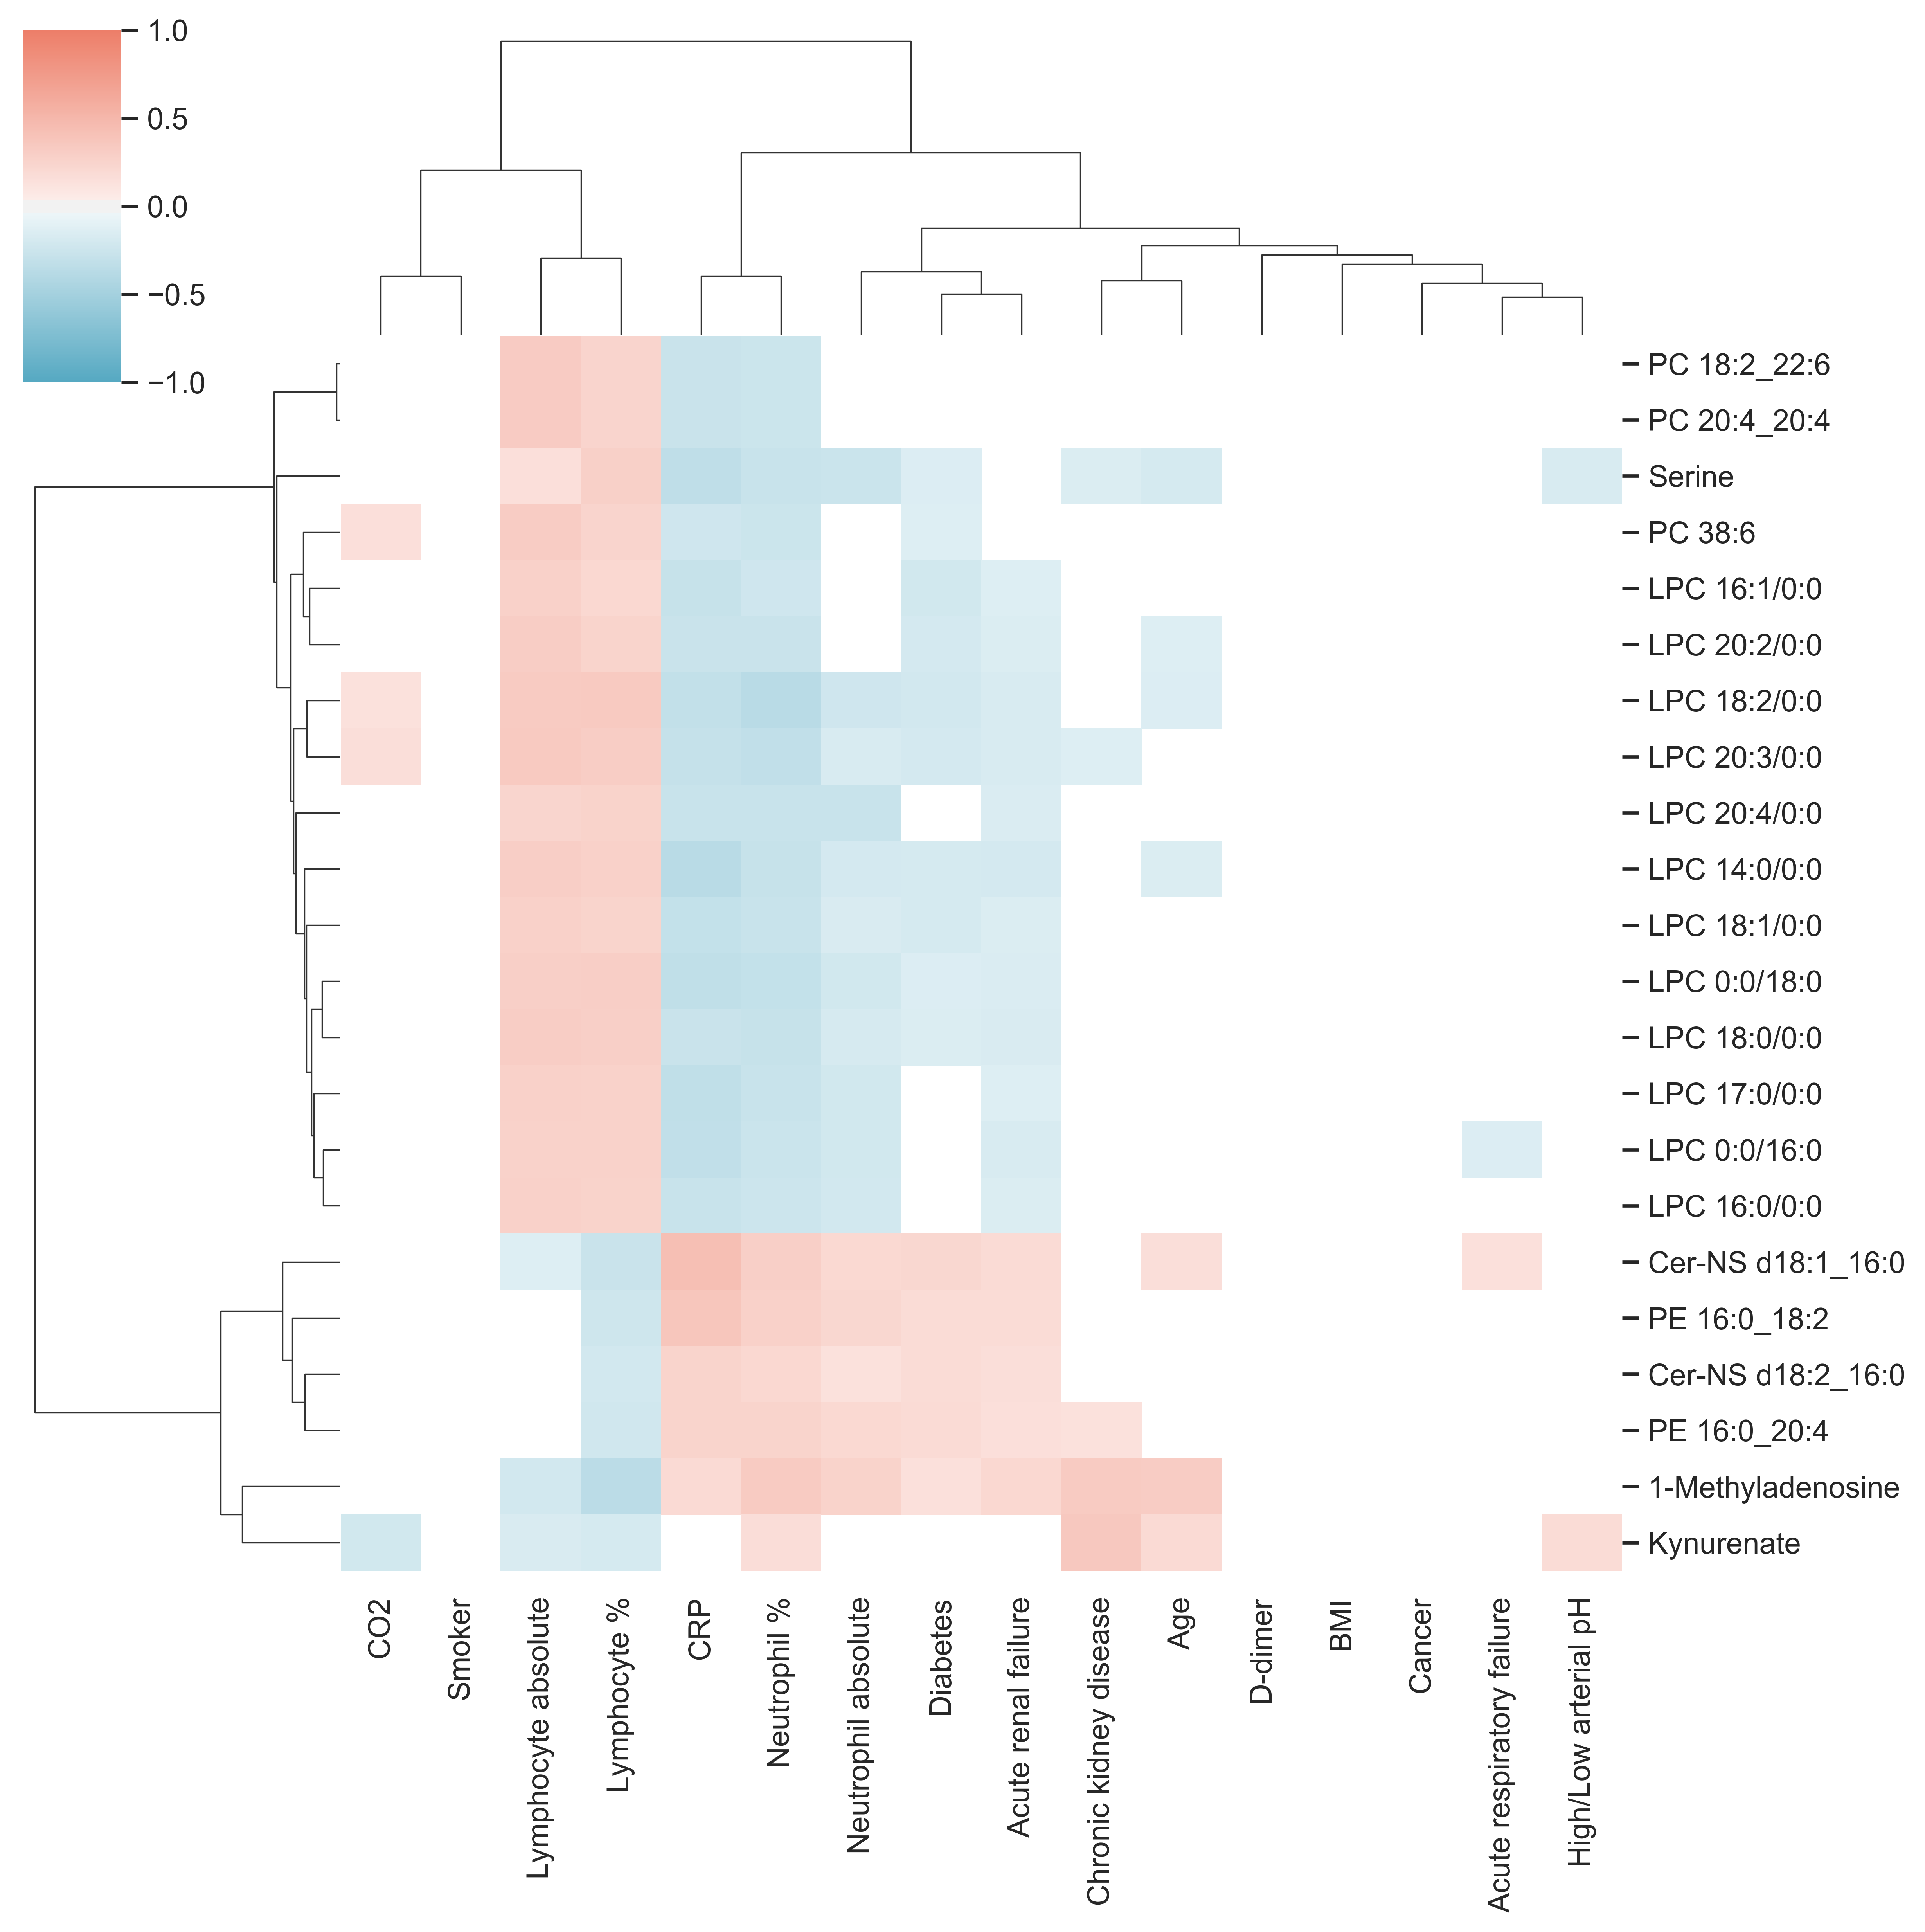

<Figure size 3000x2000 with 0 Axes>

In [14]:
sb.set(font_scale=1.0,font="Arial",style="white")

plotter = ['CRP' ,'D-dimer', 'Neutrophil %', 'CO2', 'Acute respiratory failure',
 'Diabetes', 'Acute renal failure', 'Chronic kidney disease', 'Cancer', 'BMI',
 'Age', 'Smoker', 'High/Low arterial pH', 'Neutrophil absolute',
 'Lymphocyte absolute', 'Lymphocyte %']
c = sb.clustermap(correlative_df[plotter],vmax=1.0,vmin=-1,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),mask=mask_df.astype(bool)[plotter])
c.savefig("../manuscript_figs/clinical_clustering.png")
plt.figure()

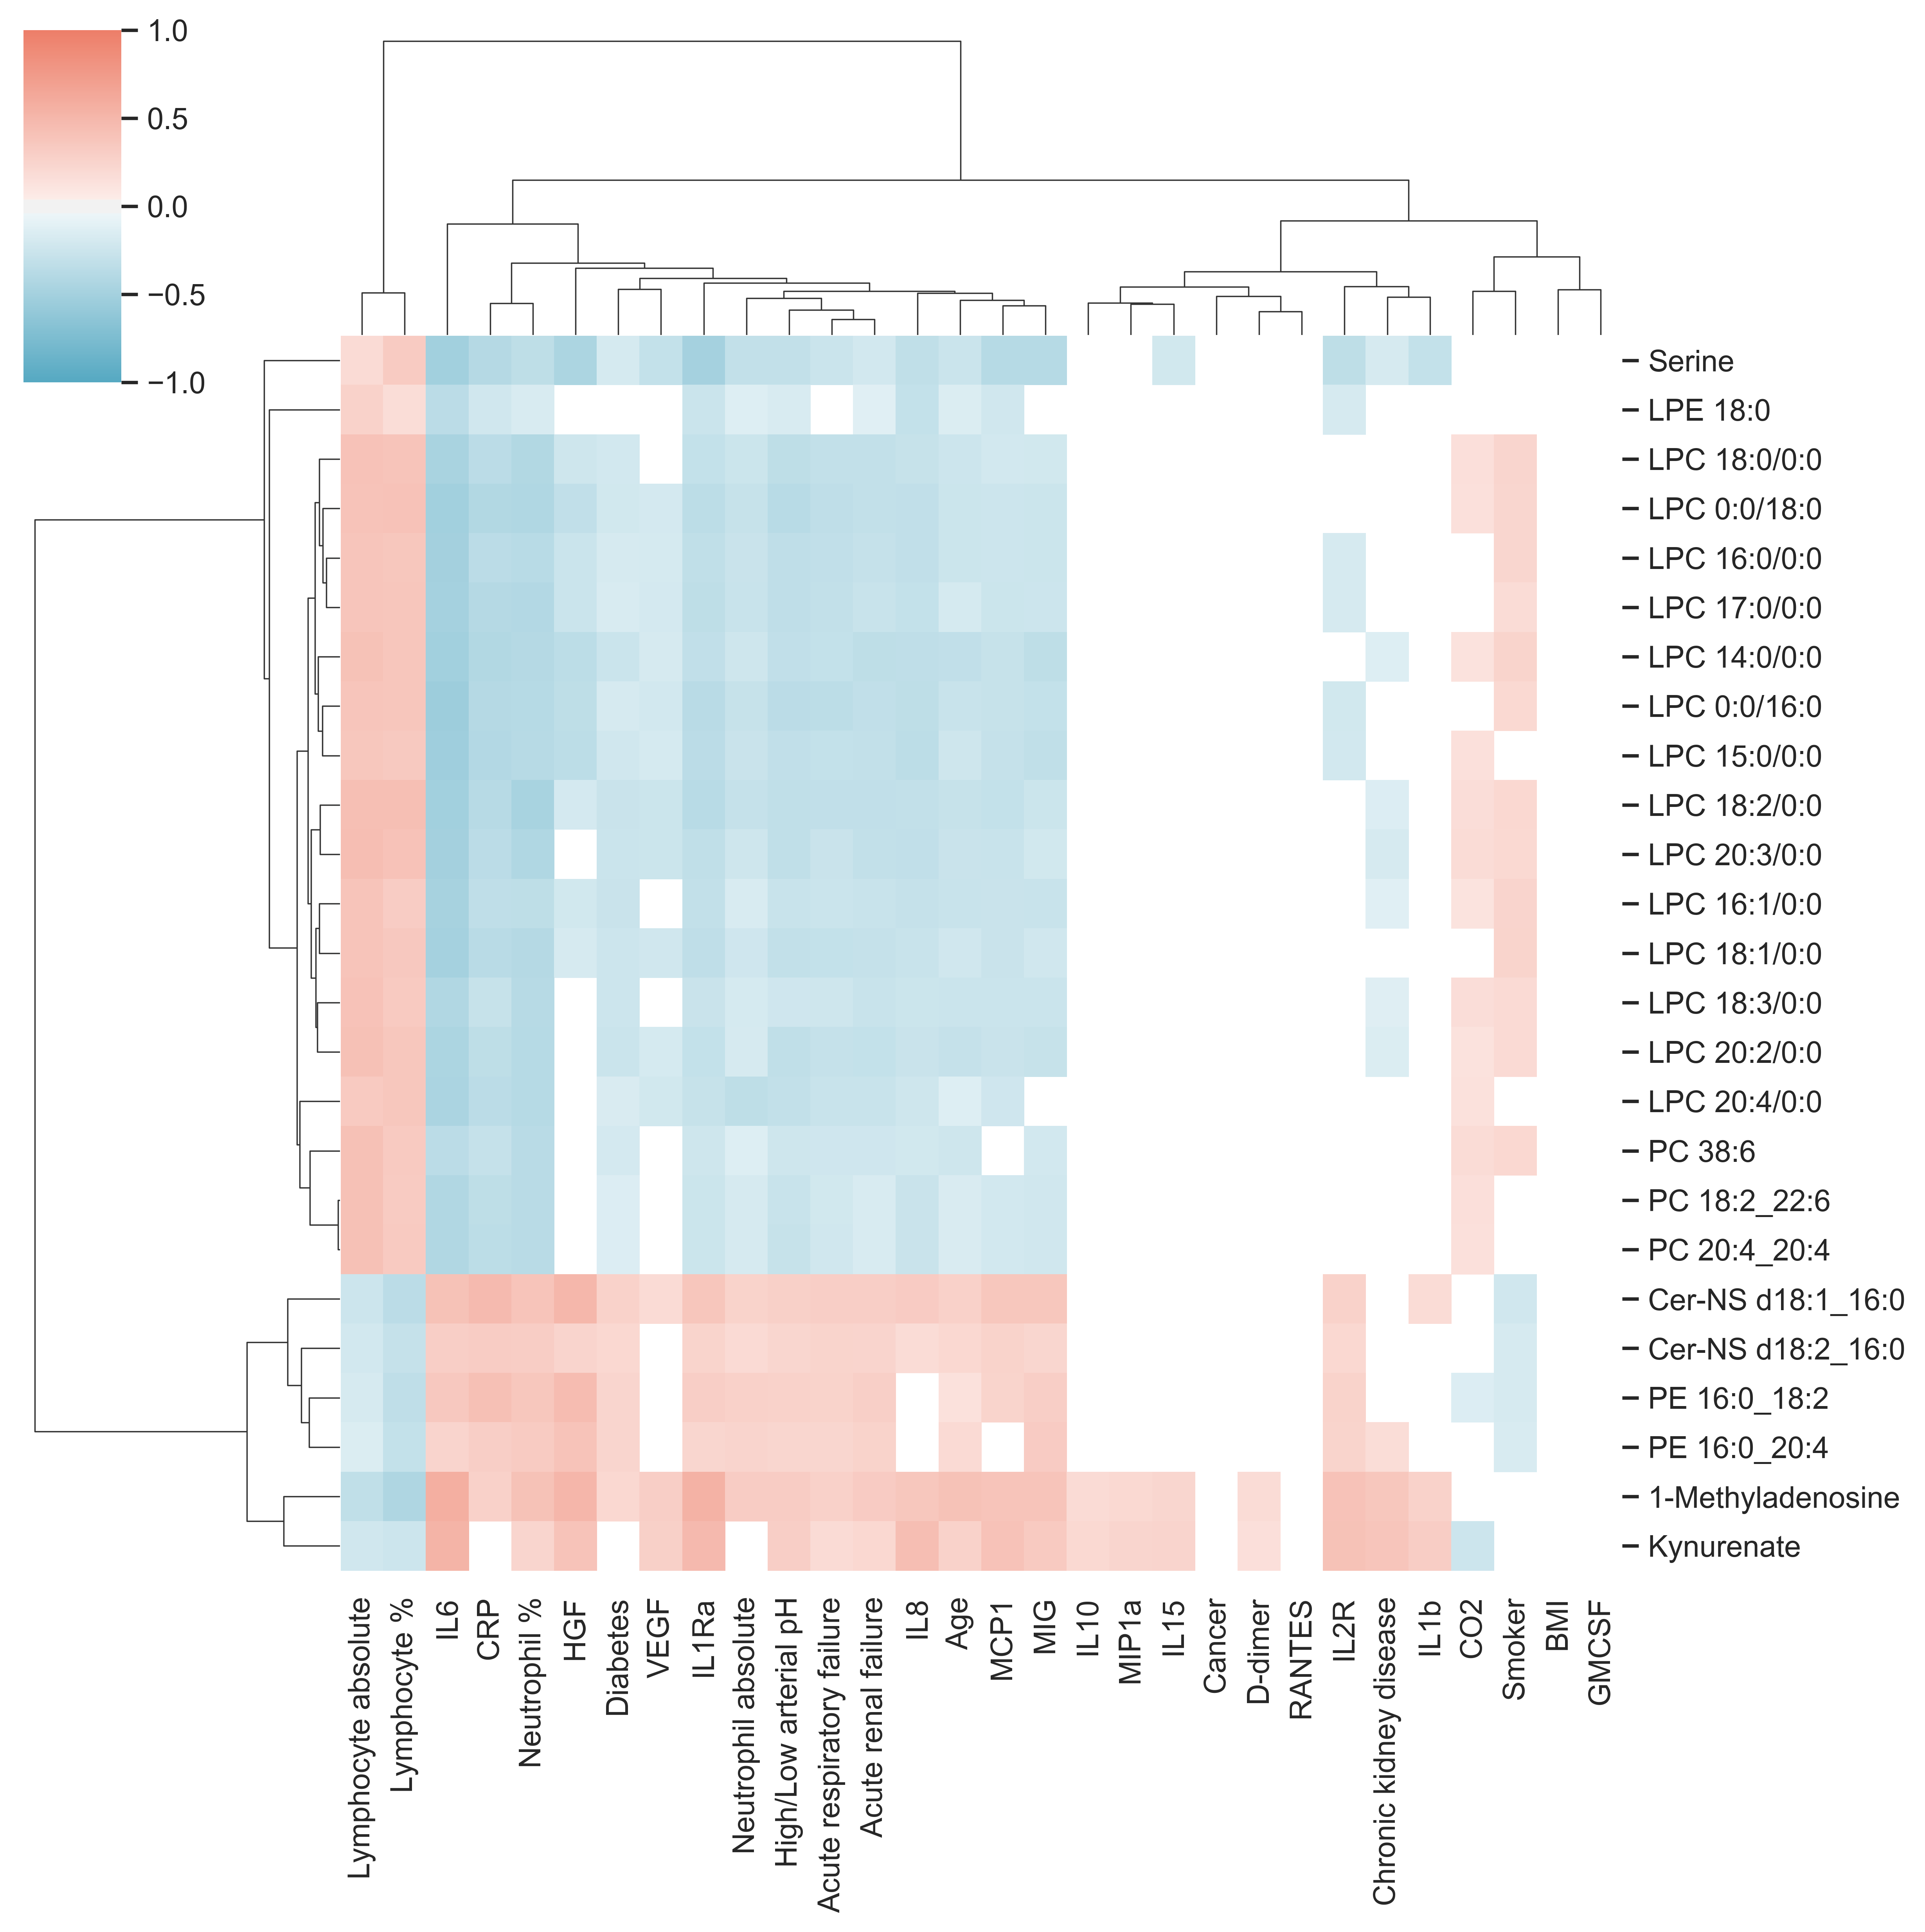

In [34]:
sb.clustermap(correlative_df,vmax=1.0,vmin=-1,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),mask=mask_df.astype(bool))


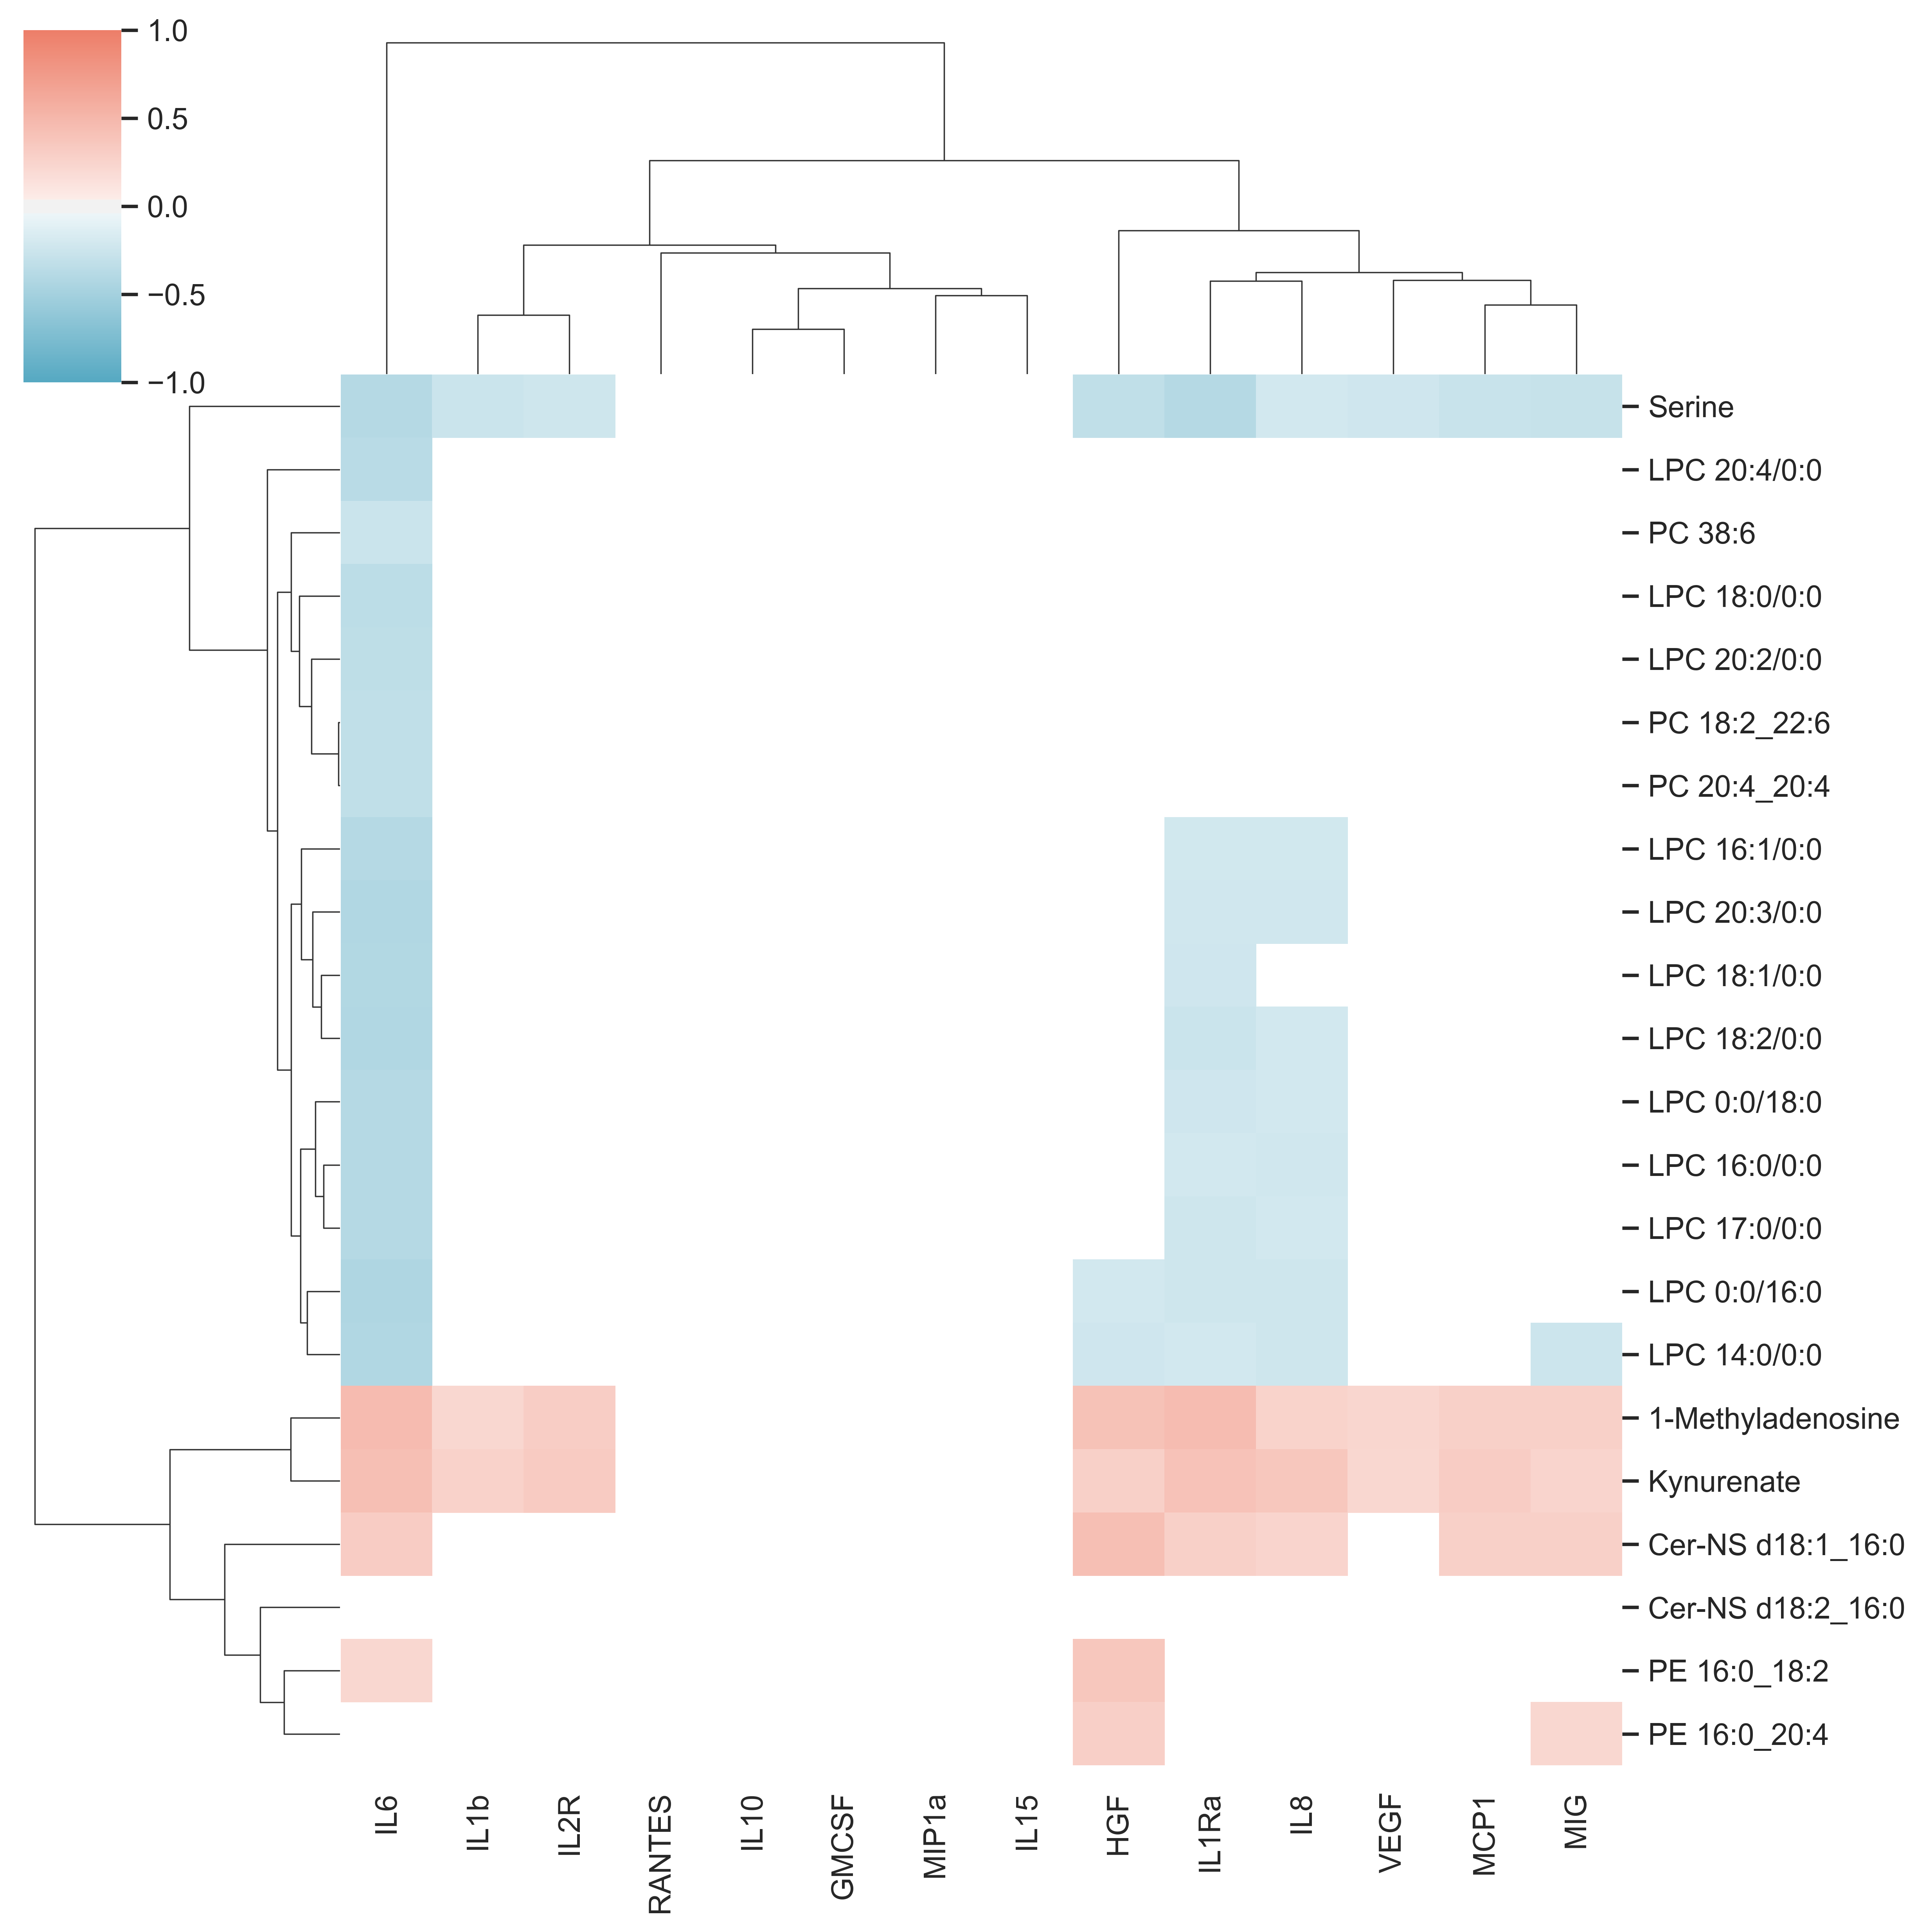

In [15]:
cytokines = ['IL1b' ,'IL10', 'IL6', 'RANTES', 'MIP1a', 'GMCSF' ,'MCP1', 'IL15' ,'HGF' ,'VEGF' ,'IL1Ra', 'IL2R', 'MIG' ,'IL8']
c = sb.clustermap(correlative_df[cytokines],vmax=1.0,vmin=-1,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),mask=mask_df.astype(bool)[cytokines])
c.savefig("../manuscript_figs/cytokine_cluster.png")


In [47]:
cross_corr_df = {}
cross_corr_pval = {}

for col in measurement_data.columns.values:
    if col != "Any drug":
        cross_corr_df[col] = {}
        cross_corr_pval[col] = {}
        for col2 in measurement_data.columns.values:
            if col2 != "Any drug":

                goodPat1 = []
                for pat in measurement_data.index.values:
                    comorb = df.at[pat,col]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            goodPat1.append(pat)

                goodPat2 = []
                for pat in measurement_data.index.values:
                    comorb = df.at[pat,col2]
                    if not pd.isna(comorb):
                        if type(comorb) == type(""):
                            comorb = comorb.replace("<","").replace(">","")
                        if float(comorb) > -.5:
                            goodPat2.append(pat)

                goodPat = set(goodPat1).intersection(goodPat2)

                val1 = []
                val2 = []
                for pat in goodPat:
                    v1 = measurement_data.at[pat,col]
                    v2 = measurement_data.at[pat,col2]
                    if type(v1) == type(""):
                        v1 = v1.replace("<","").replace(">","")
                    if type(v2) == type(""):
                        v2 = v2.replace("<","").replace(">","")
                    if float(v1) > -.5 and float(v2) > -.5:
                        if col in ["IL1b","IL10","IL6","RANTES","MIP1a","GMCSF","MCP1","IL15","HGF","VEGF","IL1Ra",
                                       "IL2R","MIG","IL8"]: v1 = np.log2(float(v1))
                        if col2 in ["IL1b","IL10","IL6","RANTES","MIP1a","GMCSF","MCP1","IL15","HGF","VEGF","IL1Ra",
                                       "IL2R","MIG","IL8"]: v2 = np.log2(float(v2))
                        val1.append(float(v1))
                        val2.append(float(v2))

                r,p = stats.pearsonr(val1,val2)
                print(col,col2,r,p)
                cross_corr_df[col][col2] = r
                cross_corr_pval[col][col2] = p

cross_corr_df = pd.DataFrame.from_dict(cross_corr_df,orient="index")
cross_corr_pval = pd.DataFrame.from_dict(cross_corr_pval,orient="index")
cross_corr_df.to_csv("../data/comorb_comorb_correlations_matrix_form_r.csv")

            





CRP CRP 0.9999999999999999 0.0
CRP D-dimer 0.15947743230850922 0.03105178052810055
CRP Neutrophil % 0.4870006349803008 4.55622986946659e-13
CRP CO2 0.0626664768741512 0.37681574162190085
CRP Acute respiratory failure 0.40898969644716804 1.6600658460257755e-09
CRP Diabetes 0.057682029401279936 0.41601107710359586
CRP Acute renal failure 0.1930485784420977 0.0060374075478127984
CRP Chronic kidney disease 0.07343369415295856 0.3001981186794977
CRP Cancer 0.035806676025386834 0.6138095739476946
CRP BMI -0.052940083775080644 0.45656476606972846
CRP Age 0.14034960649441497 0.046896223553086064
CRP Smoker -0.2035739859710342 0.060110802922122245
CRP High/Low arterial pH 0.44984165211219856 2.092634389859848e-11
CRP Neutrophil absolute 0.5557826704602685 2.7768923403580247e-17
CRP Lymphocyte absolute -0.21449274449599937 0.0024724154635014602
CRP Lymphocyte % -0.4674870158240899 4.337356198662787e-12
CRP IL1b 0.297472020261064 0.0014462349088471044
CRP IL10 0.2683897002355082 0.004220456837858

Acute respiratory failure IL15 -0.042334935091246424 0.6169029873023549
Acute respiratory failure HGF 0.3255255778021684 7.717109979581462e-05
Acute respiratory failure VEGF 0.12203277109375525 0.14796746355896476
Acute respiratory failure IL1Ra 0.2777067456348369 0.0008196422506952045
Acute respiratory failure IL2R 0.12532586599830056 0.13725376596571826
Acute respiratory failure MIG 0.1814088300868204 0.03133195377659817
Acute respiratory failure IL8 0.1612533787440476 0.055220440881594786
Diabetes CRP 0.057682029401279936 0.41601107710359586
Diabetes D-dimer 0.004232418439842738 0.9513848866886739
Diabetes Neutrophil % 0.06934750334187598 0.22875008902539598
Diabetes CO2 -0.06472145138944764 0.25745534136164866
Diabetes Acute respiratory failure 0.1486513968706817 0.00754138725894297
Diabetes Diabetes 1.0 0.0
Diabetes Acute renal failure 0.2211944017516635 6.242392816984065e-05
Diabetes Chronic kidney disease 0.2614179100926168 1.9777268115195333e-06
Diabetes Cancer 0.00832013436907

BMI High/Low arterial pH -0.0446090263305559 0.4279205760181859
BMI Neutrophil absolute -0.08951931577789869 0.12182590685531501
BMI Lymphocyte absolute 0.07084327829331749 0.2196112950925757
BMI Lymphocyte % 0.04991590165473334 0.3873750170243977
BMI IL1b -0.05498074079475917 0.5157748327216899
BMI IL10 0.06260898515813683 0.4591759284336548
BMI IL6 -0.09988696398236797 0.23691599475842293
BMI RANTES -0.1802015710761007 0.03187541608931033
BMI MIP1a -0.1090664130050242 0.19634089327398938
BMI GMCSF 0.11738199661905148 0.16415899238417514
BMI MCP1 -0.02051585811376423 0.8085172337351071
BMI IL15 -0.030096988250304966 0.7221718914968542
BMI HGF -0.09535520538008081 0.25897401490939026
BMI VEGF -0.052127978350529326 0.5378250458216997
BMI IL1Ra -0.03734537216130522 0.6590377738071653
BMI IL2R -0.08542239296584372 0.31212313440435907
BMI MIG -0.06831072247721949 0.42089750790698277
BMI IL8 -0.07539884287825031 0.37249487109333107
Age CRP 0.14034960649441497 0.046896223553086064
Age D-dime

Lymphocyte absolute IL1b -0.11123522047452856 0.19564286907400155
Lymphocyte absolute IL10 -0.019516257660491598 0.820921076494104
Lymphocyte absolute IL6 -0.37931782342274395 4.8507545392564635e-06
Lymphocyte absolute RANTES -0.01617346747279307 0.8512033077743502
Lymphocyte absolute MIP1a -0.07407890766977927 0.3896184045067377
Lymphocyte absolute GMCSF 0.007216096970092364 0.9333033535570843
Lymphocyte absolute MCP1 -0.2638051070833922 0.0018404628727657568
Lymphocyte absolute IL15 -0.08752782110561771 0.30912804446166475
Lymphocyte absolute HGF -0.11012450026476268 0.20017118152691796
Lymphocyte absolute VEGF -0.03784671269655391 0.6606014768846422
Lymphocyte absolute IL1Ra -0.25108787707946556 0.0030809517756400307
Lymphocyte absolute IL2R -0.12418446864211266 0.14822582509061516
Lymphocyte absolute MIG -0.23661296448491564 0.00554767072032392
Lymphocyte absolute IL8 -0.30644081164037357 0.0002705752944933564
Lymphocyte % CRP -0.4674870158240899 4.337356198662787e-12
Lymphocyte % 

MIP1a Diabetes -0.04823737595298768 0.5686328774409719
MIP1a Acute renal failure -0.00789770830555067 0.9256797849607727
MIP1a Chronic kidney disease 0.01090194170060779 0.8975418566874301
MIP1a Cancer 0.12227557450426152 0.14715656379967876
MIP1a BMI -0.1090664130050242 0.19634089327398938
MIP1a Age 0.1021140593906823 0.2265714110651841
MIP1a Smoker -0.10566609253840675 0.40218442121097203
MIP1a High/Low arterial pH 0.12159923938999558 0.14942373804992995
MIP1a Neutrophil absolute 0.2132733544541567 0.013005685091445245
MIP1a Lymphocyte absolute -0.07407890766977927 0.3896184045067377
MIP1a Lymphocyte % -0.08182432028727284 0.34183342215155343
MIP1a IL1b 0.581544437552841 3.227567104942399e-14
MIP1a IL10 0.47633865433605627 2.0743080535472473e-09
MIP1a IL6 0.3653555812909049 7.79330496328462e-06
MIP1a RANTES 0.2245264393733863 0.007225242574341223
MIP1a MIP1a 1.0 0.0
MIP1a GMCSF 0.38053227305618453 2.9906878227841425e-06
MIP1a MCP1 0.5285454356212029 1.373180152900119e-11
MIP1a IL15 0

VEGF Smoker -0.14647790287869533 0.24429383222158027
VEGF High/Low arterial pH 0.2129037295419162 0.010963767397835163
VEGF Neutrophil absolute 0.3488971697831866 3.365479512832265e-05
VEGF Lymphocyte absolute -0.03784671269655391 0.6606014768846422
VEGF Lymphocyte % -0.2395562918076786 0.004811101695275408
VEGF IL1b 0.46292670946984876 6.606027657620595e-09
VEGF IL10 0.33860680796803444 3.7603476793915566e-05
VEGF IL6 0.482072671281955 1.2447747357753713e-09
VEGF RANTES 0.06368207990945364 0.45149983925571746
VEGF MIP1a 0.35283160688318427 1.6574656161423252e-05
VEGF GMCSF 0.23275141483717177 0.005312845377363074
VEGF MCP1 0.4784418961706706 1.7218596852927756e-09
VEGF IL15 0.31080867941679685 0.00016677982024927116
VEGF HGF 0.3898812315321237 1.617903574526917e-06
VEGF VEGF 0.9999999999999999 0.0
VEGF IL1Ra 0.5302540716158497 1.1480919583338794e-11
VEGF IL2R 0.3990516376735386 8.692631585163229e-07
VEGF MIG 0.2287046690738111 0.006375928274815146
VEGF IL8 0.31535224783368543 0.000132

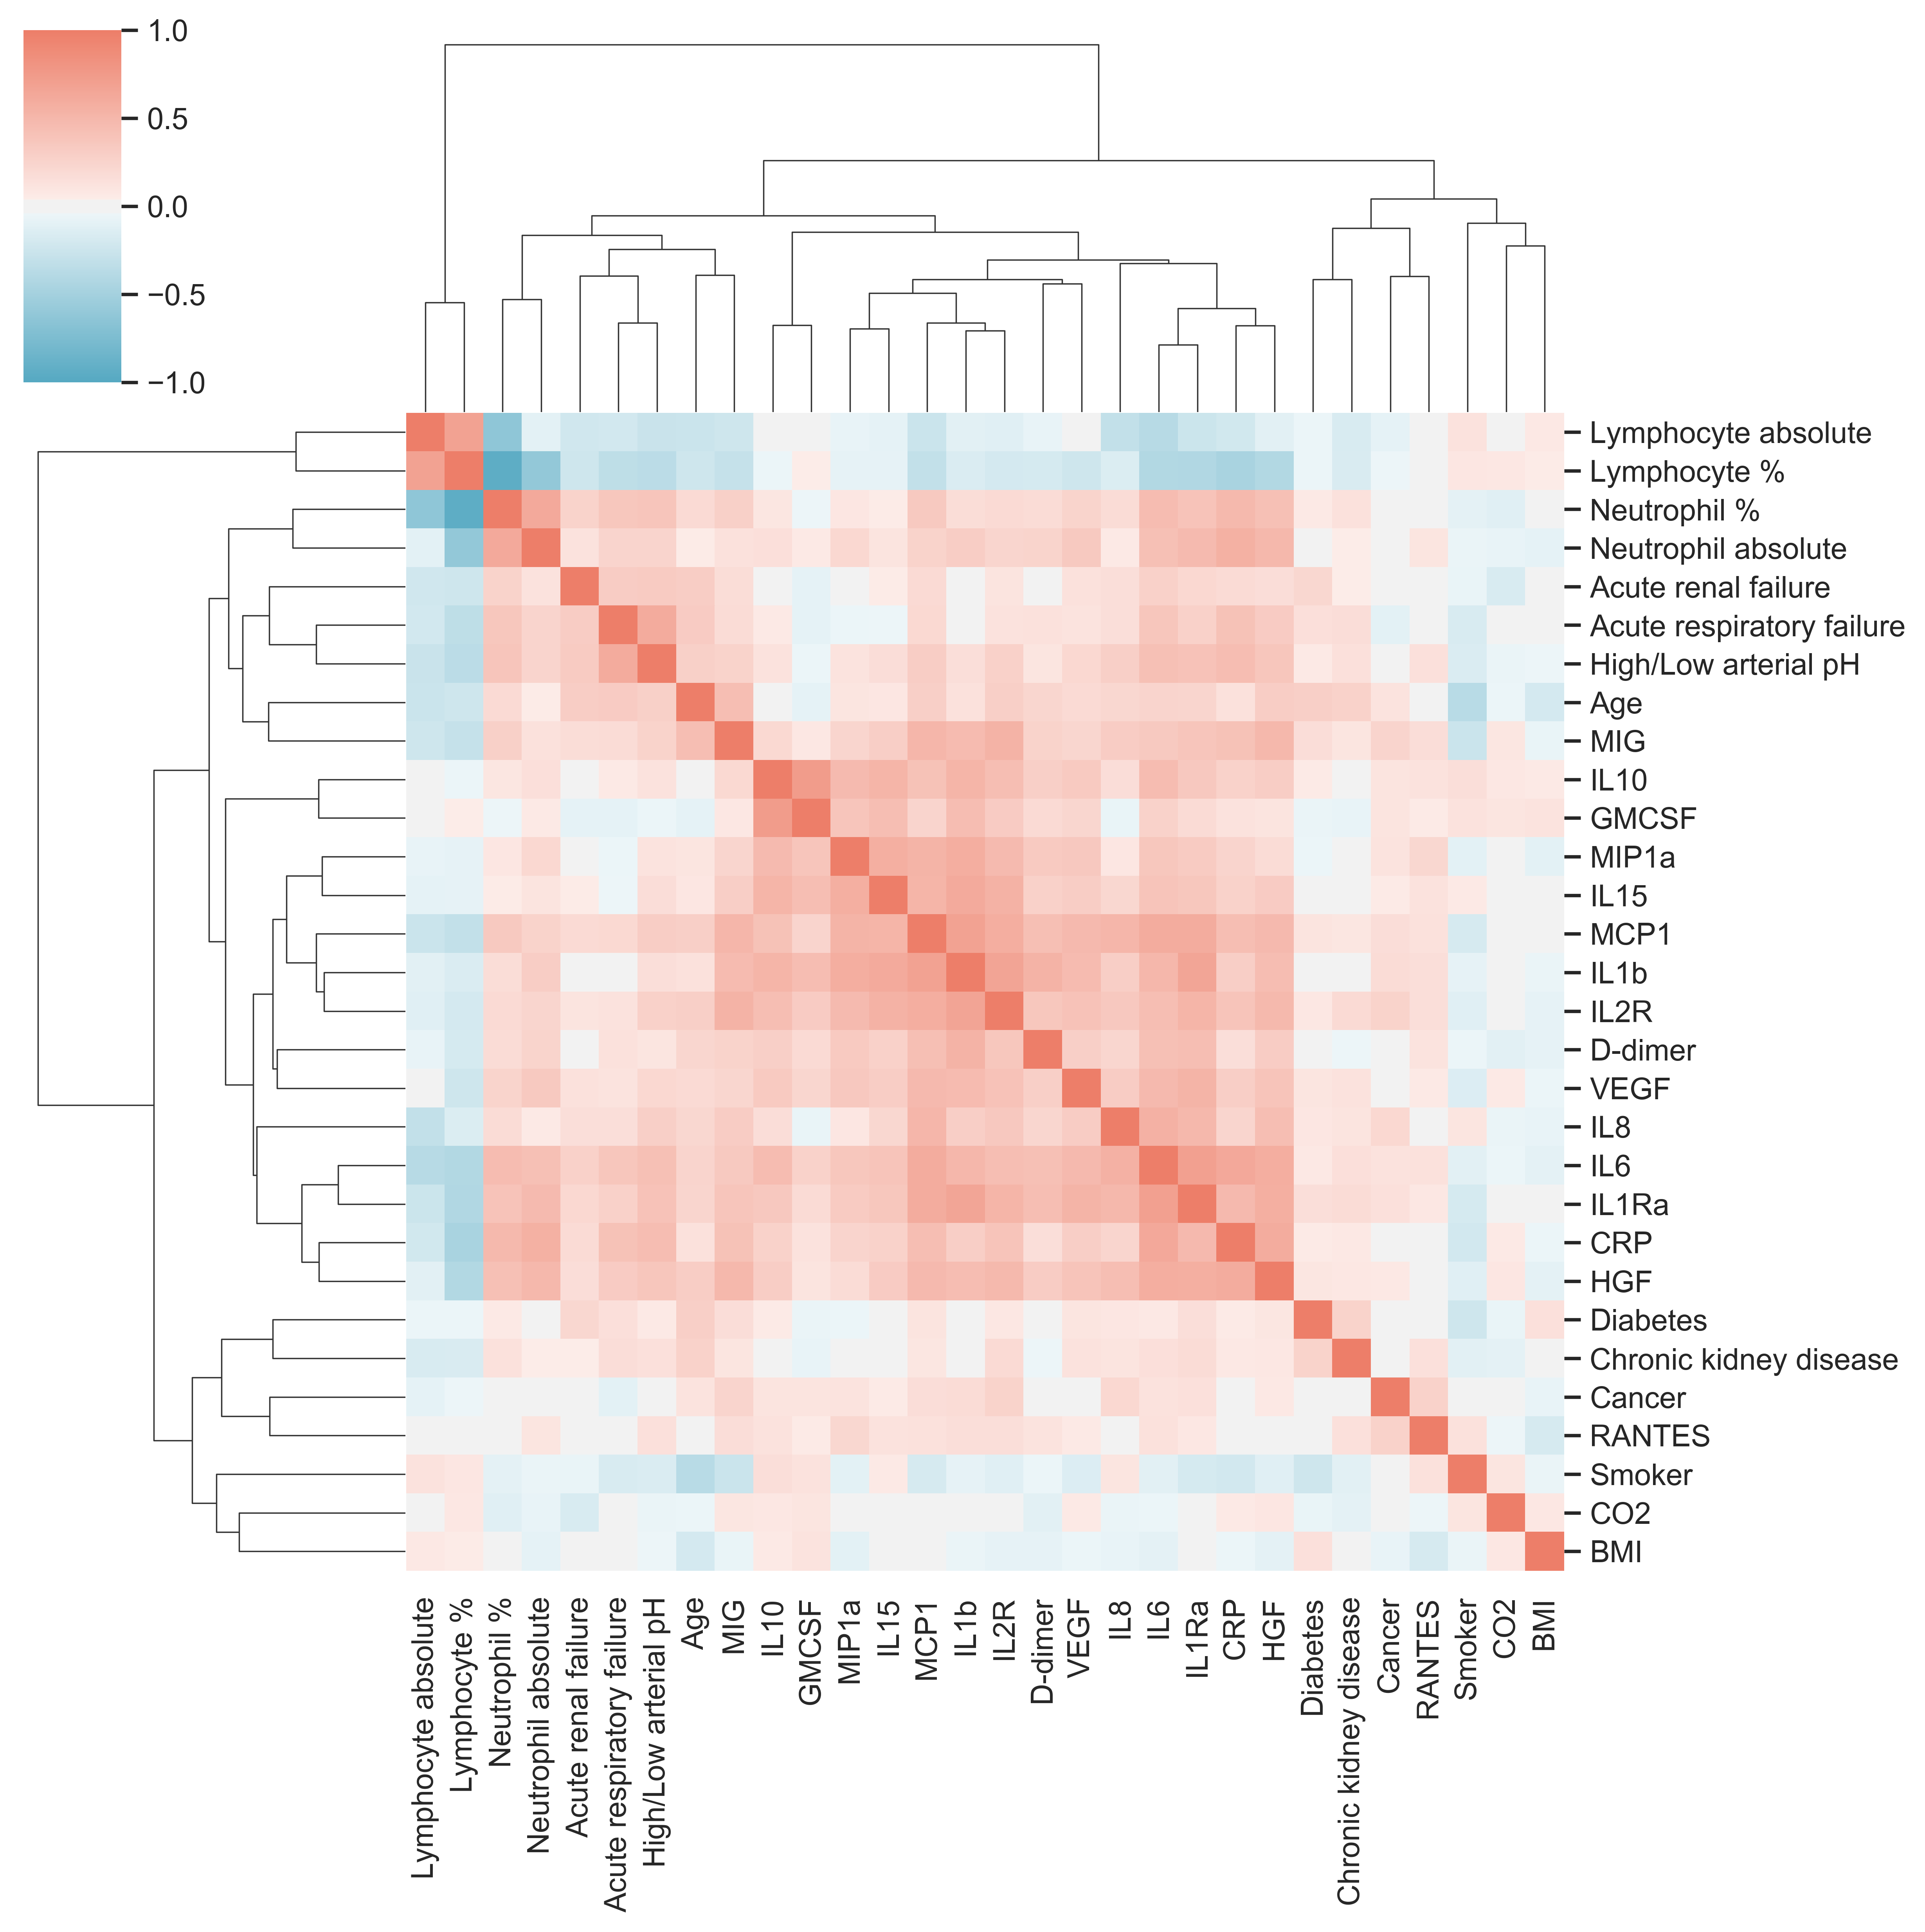

In [48]:
sb.set(font_scale=1.0)
sb.clustermap(cross_corr_df,vmax = 1.0,vmin=-1.0,cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True),dendrogram_ratio=.25)

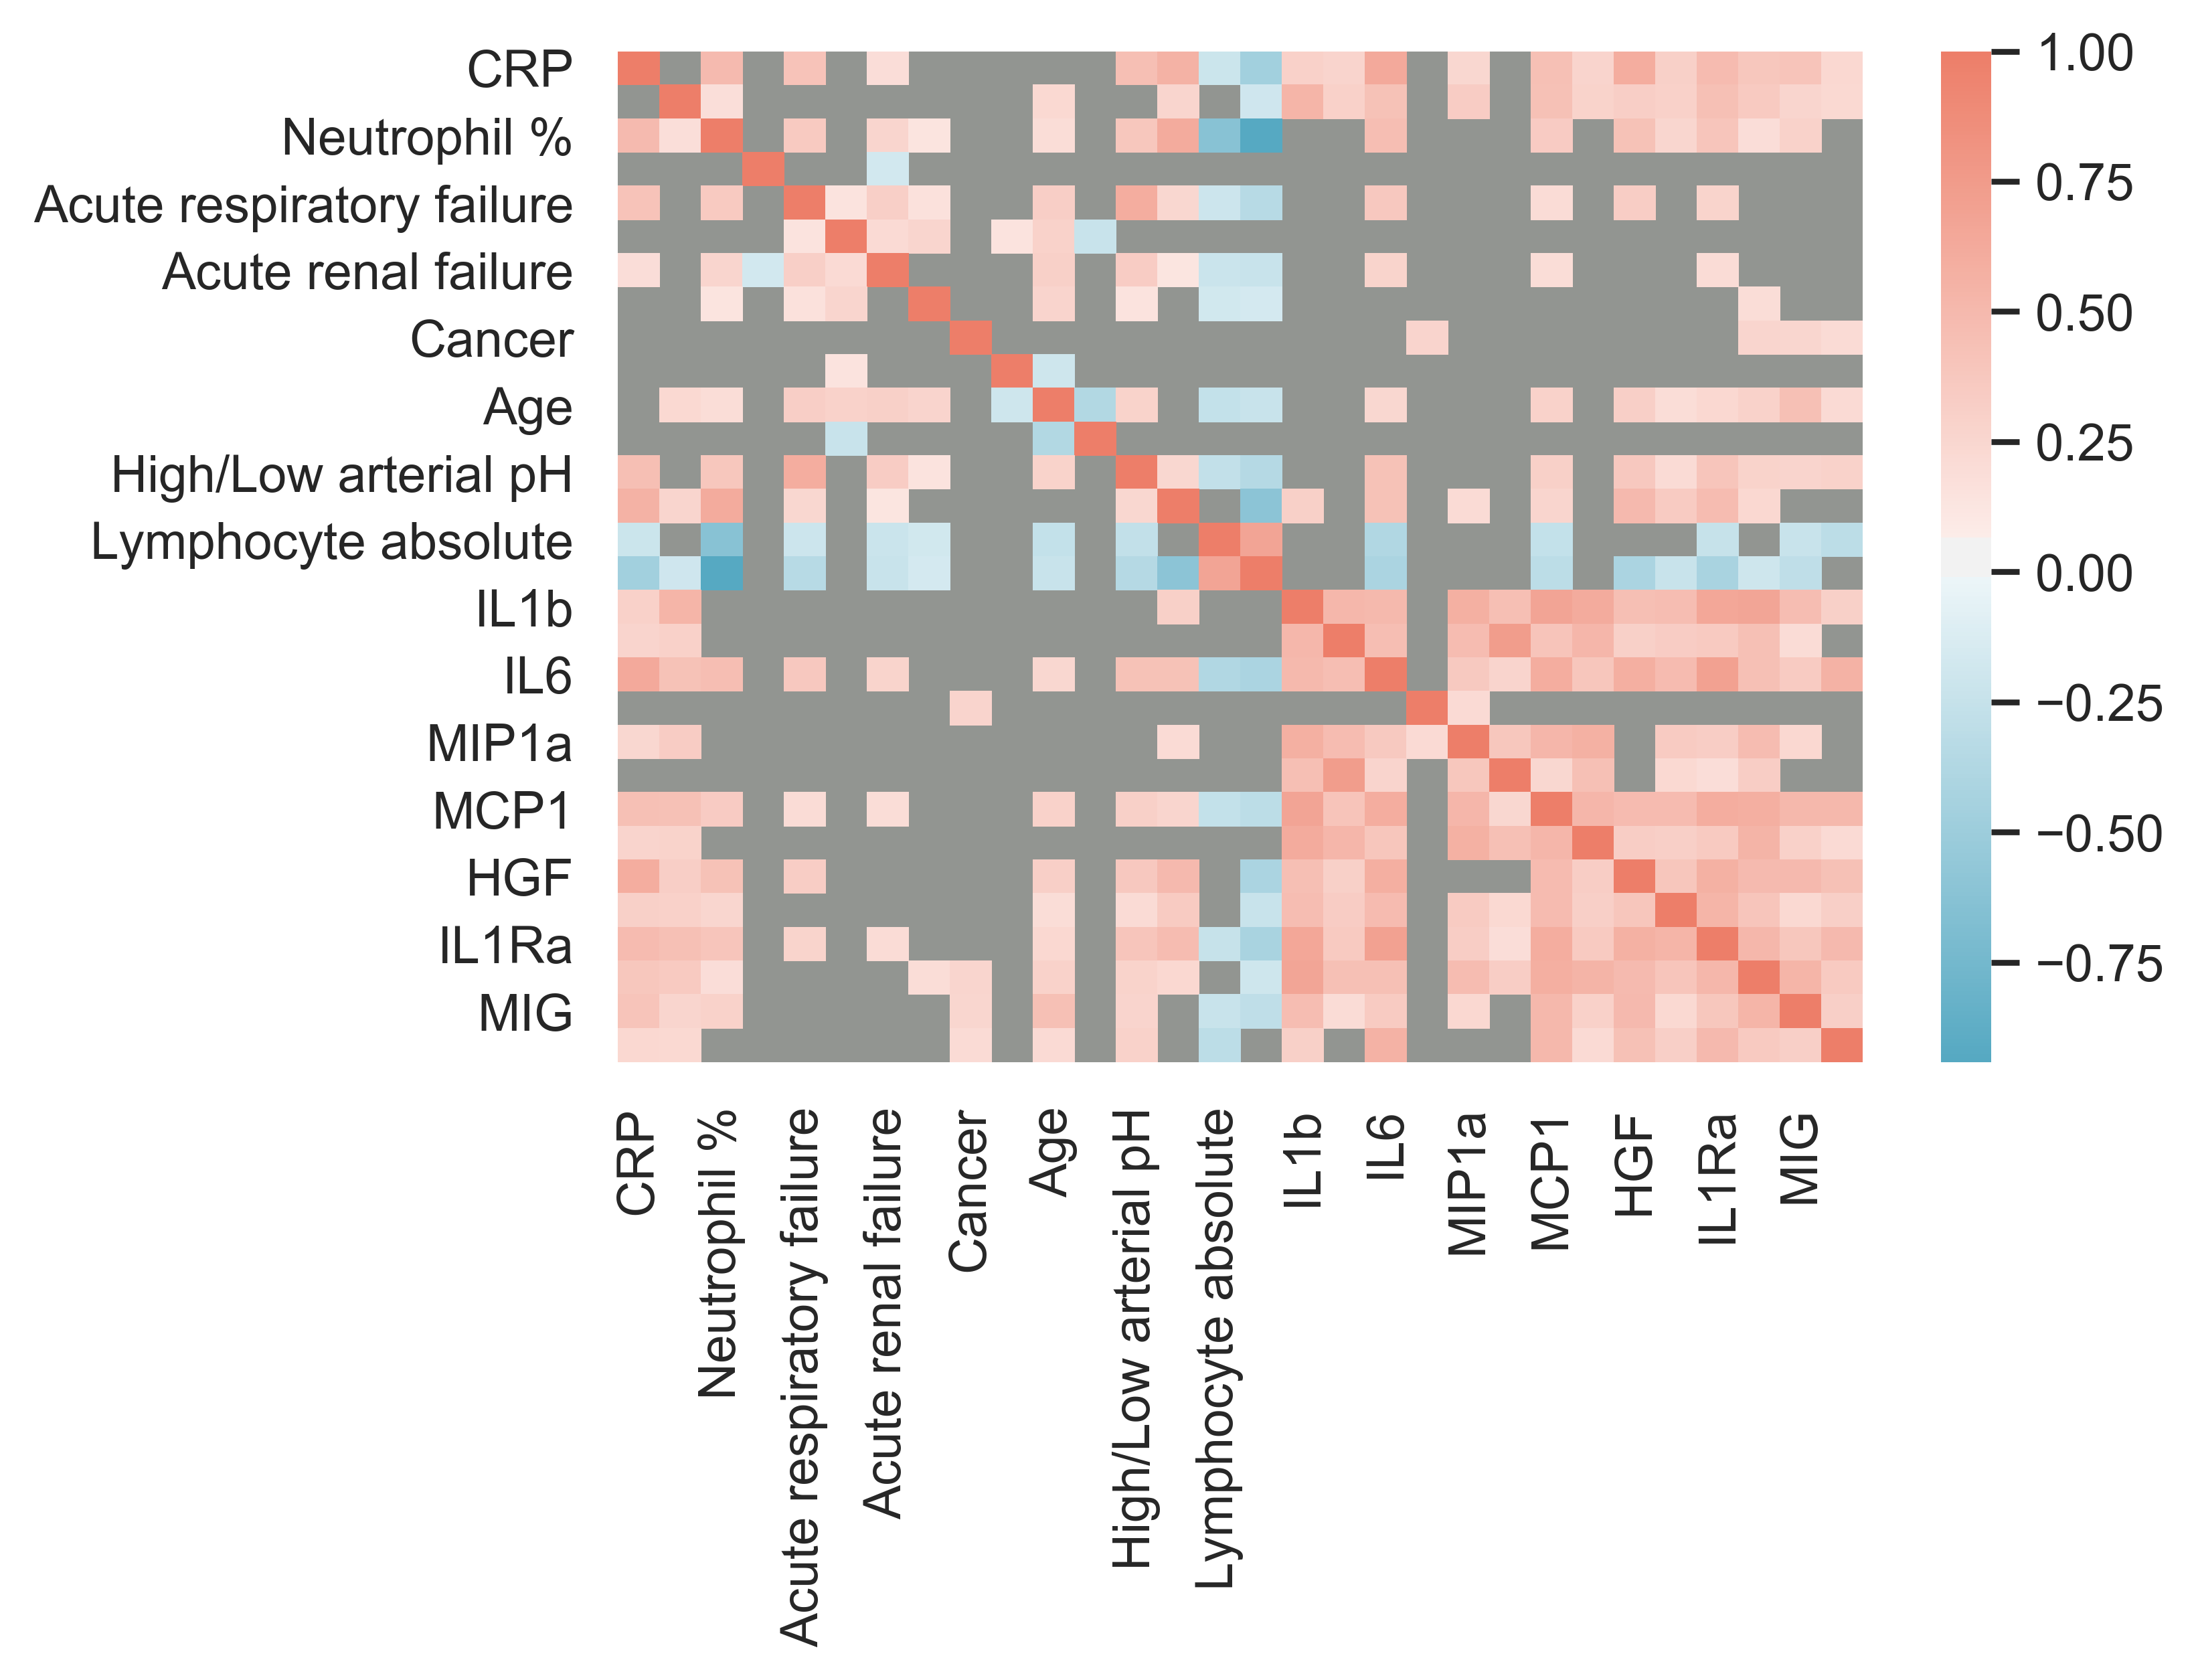

In [49]:
mask_df = deepcopy(cross_corr_pval)
ind = []
pvals = []
alpha = 0.05
for index,row in cross_corr_pval.iterrows():
    for col in cross_corr_pval.columns.values:
        ind.append((index,col))
        pvals.append(cross_corr_pval.at[index,col])

only_sig_df = {}
z = 0
reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")
found = []
for i,p in zip(ind,pvals_corr):
    if p < alpha:
        mask_df.at[i[0],i[1]] = 0
        tmp = list(i)
        tmp.sort()
        if i[0] != i[1]:
            if tmp not in found:
                found.append(tmp)
                only_sig_df[z] = {"val1":i[0],"val2":i[1],"p-value (corr)":p,"correlation":cross_corr_df.at[i[0],i[1]]}
                z += 1
    else:
        mask_df.at[i[0],i[1]] = 1
    cross_corr_pval.at[i[0],i[1]] = p
    
cross_corr_pval.to_csv("../data/comorb_comorb_correlations_matrix_form_p.csv")
only_sig_df = pd.DataFrame.from_dict(only_sig_df,orient="index").to_csv("../data/comorb_comorb_correlations_list_form.csv")        
p = sb.heatmap(cross_corr_df,mask=mask_df.astype(bool),cmap=sb.diverging_palette(220, 20, l=65, center="light", as_cmap=True))
p.set_facecolor('xkcd:grey')


['CRP' 'D-dimer' 'Neutrophil %' 'CO2' 'Acute respiratory failure'
 'Diabetes' 'Acute renal failure' 'Chronic kidney disease' 'Cancer' 'BMI'
 'Age' 'Smoker' 'High/Low arterial pH' 'Neutrophil absolute'
 'Lymphocyte absolute' 'Lymphocyte %' 'IL1b' 'IL10' 'IL6' 'RANTES' 'MIP1a'
 'GMCSF' 'MCP1' 'IL15' 'HGF' 'VEGF' 'IL1Ra' 'IL2R' 'MIG' 'IL8' 'Any drug']
234.0


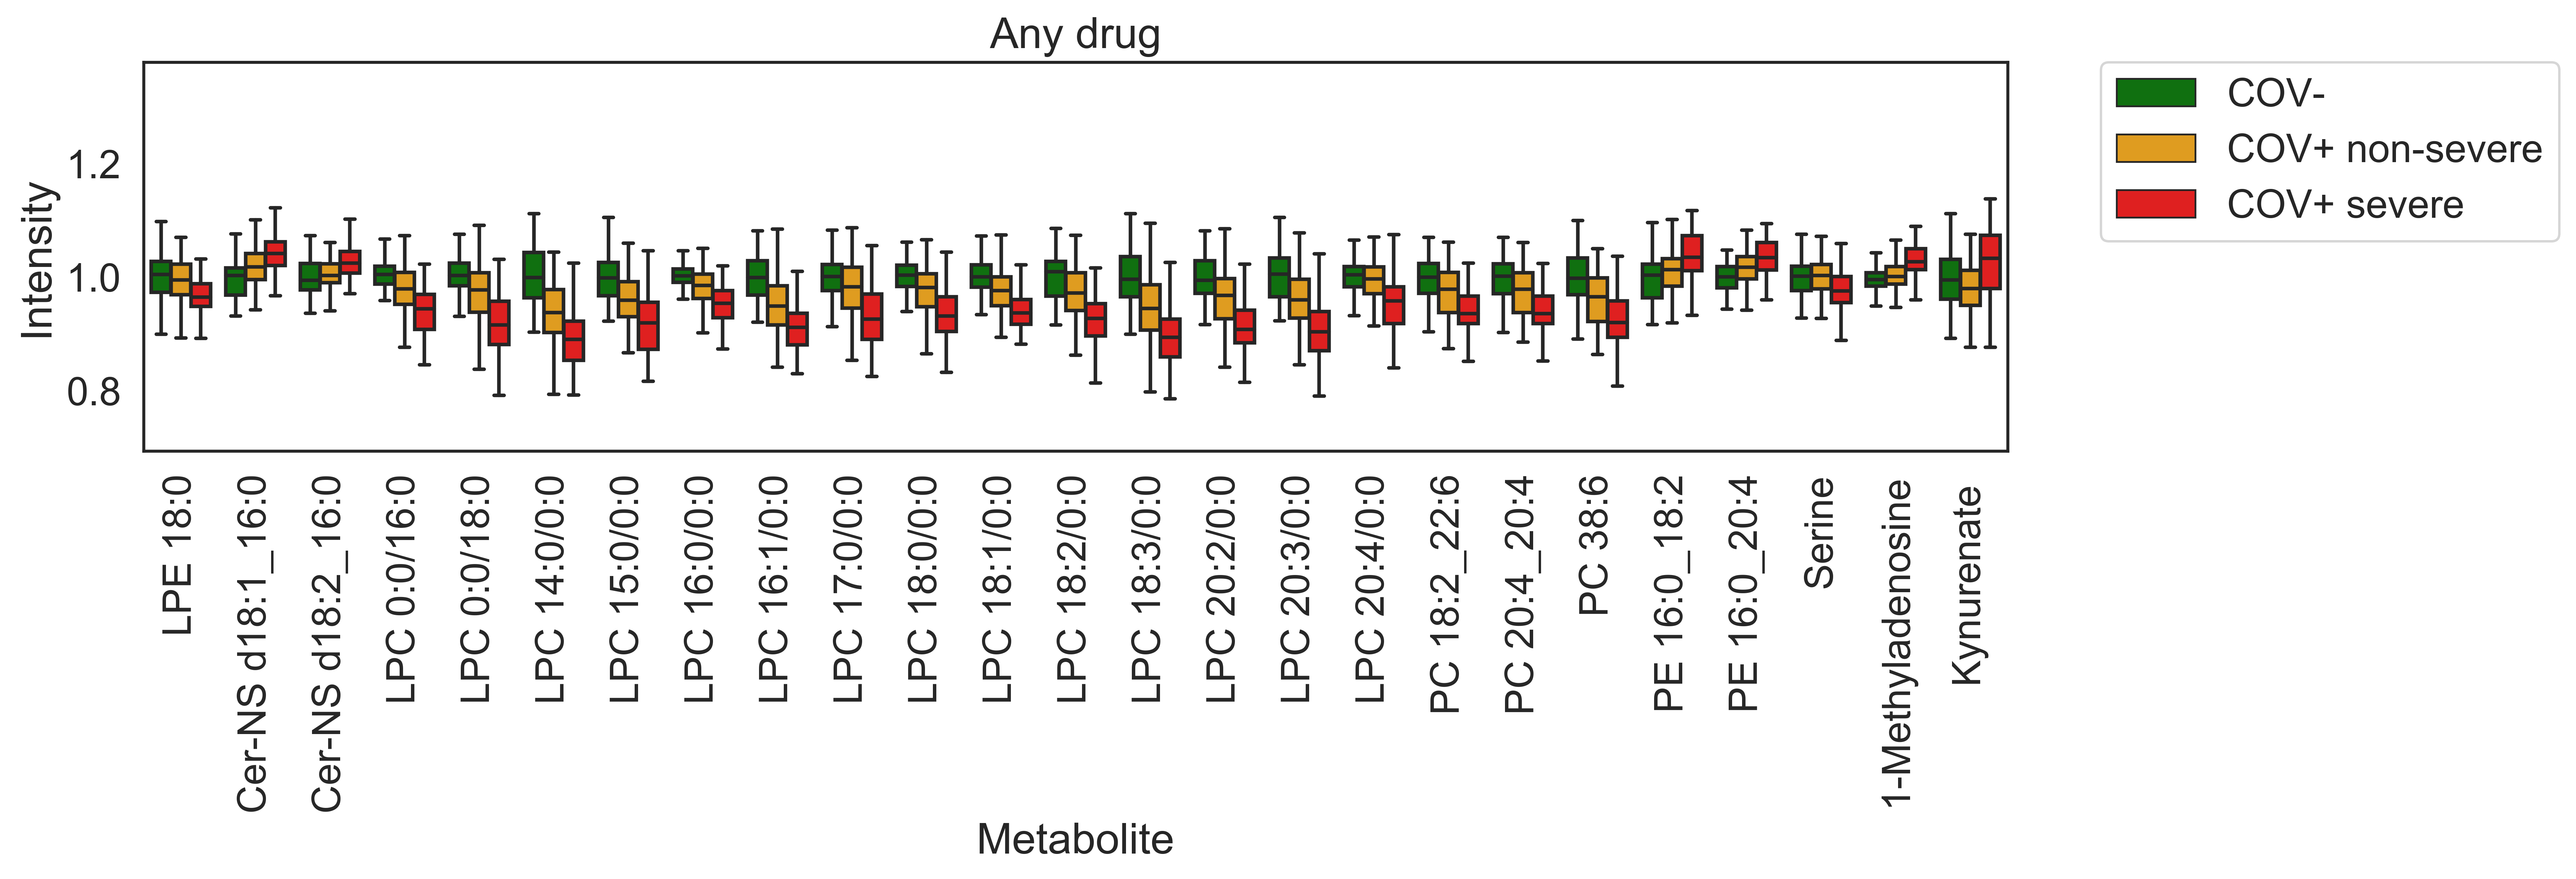

In [50]:
sb.axes_style("white")
sb.set(font_scale=1.5,font="Arial",style="white")
icu2Include = [1,0]
print(measurement_data.columns.values)
specialMapper = {"BMI":30,"Age":65}
default = .5
toTest = ["Diabetes","Acute renal failure","Chronic kidney disease","Cancer","BMI","Age","Smoker","Acute respiratory failure","BMI","Any drug"] 
toTest = ["Any drug"] 
cat2Plot = False
for col in toTest:
    cutoff = .5
    if col in specialMapper:
        cutoff = specialMapper[col]
    result = {}
    ind = 0
    for met in range(len(mol_names)):
        val = samp_int[:,met]
        indsToNorm = []
        norm = []
        for x,pat in zip(val,patient_ids):
            if pat in list(df.index.values):# and patient_ICU[pat] in icu2Include:
                comorb = df.at[pat,col]
                if not pd.isna(comorb):
                    if type(comorb) == type(""):
                        comorb = comorb.replace("<","").replace(">","")
                    if float(comorb) > -.5:
                        if comorb > cutoff:
                            comorb = True
                        else:
                            comorb = False
                         
                        covStatus = "COV-"
                        if patient_ICU[pat] < -.5 and comorb == cat2Plot:
                            norm.append(x)
                        if patient_ICU[pat] > -.5:
                            covStatus = "COV+ non-severe"
                            if patient_ICU[pat] > .5:
                                covStatus = "COV+ severe"
                        result[ind] = {"Intensity":x,"Metabolite":mol_names[met],"Patient Parameter":comorb,"COV":covStatus}
                        indsToNorm.append(ind)
                        ind += 1
        norm = np.mean(norm)
        for ind in indsToNorm:
            result[ind]["Intensity"] = result[ind]["Intensity"]/norm
            
    result = pd.DataFrame.from_dict(result,orient="index")
    result = result[result["Patient Parameter"] == cat2Plot]
    print(len(result)/25)
    
    plt.figure(figsize=(14,3))
    palette = {"COV-":"green","COV+ non-severe":"orange","COV+ severe":"red"}
    ax = sb.boxplot(data=result,x="Metabolite",y="Intensity",hue="COV",fliersize=0,palette=palette,hue_order=["COV-","COV+ non-severe","COV+ severe"])
    #sb.swarmplot(data=result,x="Metabolite",y="Intensity",hue="COV",dodge=True,palette=palette,hue_order=["COV+ non-severe","COV+ severe"])
    plt.title(col)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=90)


In [51]:
sb.axes_style("white")
sb.set(font_scale=1.5,font="Arial",style="white")
icu2Include = [1,0]
print(measurement_data.columns.values)
specialMapper = {"BMI":30,"Age":65}
default = .5
toTest = ["Diabetes","Acute renal failure","Chronic kidney disease","Cancer","BMI","Age","Smoker","Acute respiratory failure","BMI","Any drug"] 
toTest = ["Any drug"] 
cat2Plot = False
for col in toTest:
    cutoff = .5
    if col in specialMapper:
        cutoff = specialMapper[col]
    result = {}
    ind = 0
    for met in range(len(mol_names)):
        val = samp_int[:,met]
        indsToNorm = []
        norm = []
        for x,pat in zip(val,patient_ids):
            if pat in list(df.index.values):# and patient_ICU[pat] in icu2Include:
                comorb = df.at[pat,col]
                if not pd.isna(comorb):
                    if type(comorb) == type(""):
                        comorb = comorb.replace("<","").replace(">","")
                    if float(comorb) > -.5:
                        if comorb > cutoff:
                            comorb = True
                        else:
                            comorb = False
                         
                        covStatus = "COV-"
                        if patient_ICU[pat] < -.5 and comorb == cat2Plot:
                            norm.append(x)
                        if patient_ICU[pat] > -.5:
                            covStatus = "COV+ non-severe"
                            if patient_ICU[pat] > .5:
                                covStatus = "COV+ severe"
                        result[ind] = {"Intensity":x,"Metabolite":mol_names[met],"Patient Parameter":comorb,"COV":covStatus}
                        indsToNorm.append(ind)
                        ind += 1

            
    result = pd.DataFrame.from_dict(result,orient="index")
    result = result[result["Patient Parameter"] == cat2Plot]
  
    pvals = []
    for met in range(len(mol_names)):
        name = mol_names[met]
        args = []
        for cat in ["COV-","COV+ non-severe","COV+ severe"]:
            tmp = result[result["Metabolite"] == name]
            tmp = tmp[tmp["COV"] == cat]
            args.append(tmp["Intensity"].values)
        stat,p = welch_anova_np(*args)
        pvals.append(p)
    
    alpha = 0.05
    reject,pvals_corr,_,_ = multipletests(pvals,alpha,method="fdr_bh")

    for name,p in zip(mol_names,pvals_corr):
        print(name,p)


['CRP' 'D-dimer' 'Neutrophil %' 'CO2' 'Acute respiratory failure'
 'Diabetes' 'Acute renal failure' 'Chronic kidney disease' 'Cancer' 'BMI'
 'Age' 'Smoker' 'High/Low arterial pH' 'Neutrophil absolute'
 'Lymphocyte absolute' 'Lymphocyte %' 'IL1b' 'IL10' 'IL6' 'RANTES' 'MIP1a'
 'GMCSF' 'MCP1' 'IL15' 'HGF' 'VEGF' 'IL1Ra' 'IL2R' 'MIG' 'IL8' 'Any drug']
LPE 18:0 1.2084952566441852e-06
Cer-NS d18:1_16:0 1.4400963974600209e-09
Cer-NS d18:2_16:0 3.6476590120681533e-06
LPC 0:0/16:0 1.961449338104675e-15
LPC 0:0/18:0 1.0019420962311497e-15
LPC 14:0/0:0 1.11649914068401e-17
LPC 15:0/0:0 3.5806508496607515e-14
LPC 16:0/0:0 1.3927303147619109e-14
LPC 16:1/0:0 1.238551888400427e-16
LPC 17:0/0:0 4.1937078350602605e-12
LPC 18:0/0:0 1.1764516601232131e-14
LPC 18:1/0:0 1.3927303147619109e-14
LPC 18:2/0:0 4.373651331039522e-14
LPC 18:3/0:0 6.294044127512361e-14
LPC 20:2/0:0 7.116702605254631e-16
LPC 20:3/0:0 5.455958256768246e-14
LPC 20:4/0:0 1.4558696762862778e-09
PC 18:2_22:6 5.480519014905656e-12
PC 2